In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import svd
import json
from geopy.distance import geodesic
import statistics
import random

# Tokyo Metro

[Tokyo Metro Data Github](https://github.com/Jugendhackt/tokyo-metro-data/tree/master) 


## Set up

In [ ]:
distances_df=pd.read_csv("matrix_dist.csv")
names_df=pd.read_csv("stations_eng.csv",header=None)
distances_df

,Unnamed: 0,G01,G02,G03,G04,G05,G06,G07,G08,G09,...,A14,A15,A16,A17,A18,A19,A20,Mb03,Mb04,Mb05
0,G01,-1.0,1.3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,G02,1.3,-1.0,0.7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,G03,-1.0,0.7,-1.0,0.7,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,G04,-1.0,-1.0,0.7,-1.0,1.3,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,G05,-1.0,-1.0,-1.0,1.3,-1.0,0.9,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,A19,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,0.7,-1.0,0.8,-1.0,-1.0,-1.0
287,A20,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,0.8,-1.0,-1.0,-1.0,-1.0
288,Mb03,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.3,-1.0
289,Mb04,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.3,-1.0,0.6


In [ ]:
names_df[1]=names_df[1].astype(str)
names_df[1]=["0"+entry if len(entry)==1 else entry for entry in list(names_df[1])]
names_df["stop"]=names_df[0]+names_df[1] #concatenating the letter and number columns. Ex G+02=G02 stop
names_df.rename(columns={2: "station"},inplace=True)
names_df=names_df[["stop","station"]]

stations=dict(zip(names_df.stop,names_df.station)) #dictionary of the stops and corresponding station names
stations["M13"]='Akasaka-mitsuke' #downloaded data had a typo :/

In [ ]:
distances_df.rename(columns={"Unnamed: 0":"stops"},inplace=True)
station_names=[stations[stop] for stop in distances_df["stops"]] #station names to replace stop names
distances_df.drop(["stops"],axis=1,inplace=True)
distances_df.index=station_names
distances_df.columns=station_names

In [ ]:
distances_df

,Shibuya,Ometo-sando,Gaiemmae,Aoyama-itchome,Akasaka-mitsuke,Tameiki-sanno,Toranomon Hills,Shimbashi,Ginza,Kyobashi,...,Ningyocho,Higashi-Nihombashi,Asakusabashi,Kuramae,Asakusa,Honjo-azumabashi,Oshiage <SKYTREE>,Nonancho,Nakano-fujimicho,Nakano-shimbashi
Shibuya,-1.0,1.3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Ometo-sando,1.3,-1.0,0.7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Gaiemmae,-1.0,0.7,-1.0,0.7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Aoyama-itchome,-1.0,-1.0,0.7,-1.0,1.3,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
Akasaka-mitsuke,-1.0,-1.0,-1.0,1.3,-1.0,0.9,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Honjo-azumabashi,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,0.7,-1.0,0.8,-1.0,-1.0,-1.0
Oshiage <SKYTREE>,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,0.8,-1.0,-1.0,-1.0,-1.0
Nonancho,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.3,-1.0
Nakano-fujimicho,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.3,-1.0,0.6


In [ ]:
distances_df.replace(-1,0, inplace=True) #distances of -1 mean no edge exists

#combine stops that all stop at one station
distances_df=distances_df.groupby(distances_df.index).sum() #sum rows that have same station name
distances_df=distances_df.groupby(level=0,axis=1).sum() #sum over columns that have same station name

/tmp/ipykernel_86/1653937417.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  distances_df=distances_df.groupby(level=0,axis=1).sum() #sum over columns that have same station name


In [ ]:
node_names=list(distances_df.columns)
node_names

['Akabane-iwabuchi',
 'Akabanebashi',
 'Akasaka',
 'Akasaka-mitsuke',
 'Akebonobashi',
 'Akihabara',
 'Aoyama-itchome',
 'Asakusa',
 'Asakusabashi',
 'Awajicho',
 'Ayase',
 'Azabu-juban',
 'Bakuro yokoyama',
 'Baraki-nakayama',
 'Chikatetsu-akatsuka',
 'Chikatetsu-narimasu',
 'Daimon',
 'Ebisu',
 'Edogawabashi',
 'Funabori',
 'Gaiemmae',
 'Ginza',
 'Ginza-itchome',
 'Gokokuji',
 'Gotando',
 'Gyotoku',
 'Hagashi-shinjuku',
 'Hakusan',
 'Hamacho',
 'Hanzomon',
 'Hasuna',
 'Hatchobori',
 'Heiwadai',
 'Hibiya',
 'Higashi-Nihombashi',
 'Higashi-ginza',
 'Higashi-ikebukuro',
 'Higashi-koenji',
 'Higashi-nakano',
 'Higashi-ojima',
 'Higashi-shinjuku',
 'Hikarigaoka',
 'Hikawadai',
 'Hiro-o',
 'Hon-komagome',
 'Hongo-sanchome',
 'Honjo-azumabashi',
 'Ichigaya',
 'Ichinoe',
 'Iidabashi',
 'Ikebukuro',
 'Inaricho',
 'Iriya',
 'Itabashi-kuyakushomae',
 'Itabashihoncho',
 'Iwamotocho',
 'Jimbocho',
 'Kachidoki',
 'Kagurazaka',
 'Kamiyacho',
 'Kanamecho',
 'Kanda',
 'Kasai',
 'Kasuga',
 'Kasumigase

In [ ]:
distances_G=nx.from_pandas_adjacency(distances_df) #graph with raw distances
weights_G=nx.from_pandas_adjacency(distances_df) #graph with weights -> inverses of distances

In [ ]:
for edge in list(weights_G.edges(data=True)):
   weights_G.edges[edge[0],edge[1]]['weight']=1/(edge[2]["weight"])  #update distances to weights

In [ ]:
nx.relabel_nodes(distances_G, dict(zip(list(distances_G.nodes()),node_names)),copy=False) #adds node names
nx.relabel_nodes(weights_G, dict(zip(list(weights_G.nodes()),node_names)),copy=False) #adds node names

In [ ]:
with open("station_coord.json") as file:
  coord_data=json.load(file)

In [ ]:
for node in list(distances_G.nodes):
    distances_G.add_node(node, coordinates=coord_data[node])
    weights_G.add_node(node, coordinates=coord_data[node])

In [ ]:
print(distances_G.edges(data=True))

[('Akabane-iwabuchi', 'Shimo', {'weight': 1.1}), ('Akabanebashi', 'Azabu-juban', {'weight': 0.8}), ('Akabanebashi', 'Daimon', {'weight': 1.3}), ('Akasaka', 'Kokkai-gijidomae', {'weight': 0.8}), ('Akasaka', 'Nogizaka', {'weight': 1.1}), ('Akasaka-mitsuke', 'Aoyama-itchome', {'weight': 1.3}), ('Akasaka-mitsuke', 'Kokki-gijidomae', {'weight': 0.9}), ('Akasaka-mitsuke', 'Tameiki-sanno', {'weight': 0.9}), ('Akasaka-mitsuke', 'Yotasuya', {'weight': 1.3}), ('Akebonobashi', 'Ichigaya', {'weight': 1.4}), ('Akebonobashi', 'Shinjuku-sanchome', {'weight': 1.5}), ('Akihabara', 'Kodemmacho', {'weight': 0.9}), ('Akihabara', 'Naka-okachimachi', {'weight': 1.0}), ('Aoyama-itchome', 'Gaiemmae', {'weight': 0.7}), ('Aoyama-itchome', 'Kokuritsu-kyogijo', {'weight': 1.2}), ('Aoyama-itchome', 'Nagatacho', {'weight': 1.4}), ('Aoyama-itchome', 'Omote-sando', {'weight': 1.4}), ('Aoyama-itchome', 'Roppongi', {'weight': 1.3}), ('Asakusa', 'Honjo-azumabashi', {'weight': 0.7}), ('Asakusa', 'Kuramae', {'weight': 0.9

In [ ]:
distances_G.nodes["Akihabara"]["coordinates"]

[35.6987676, 139.774255]

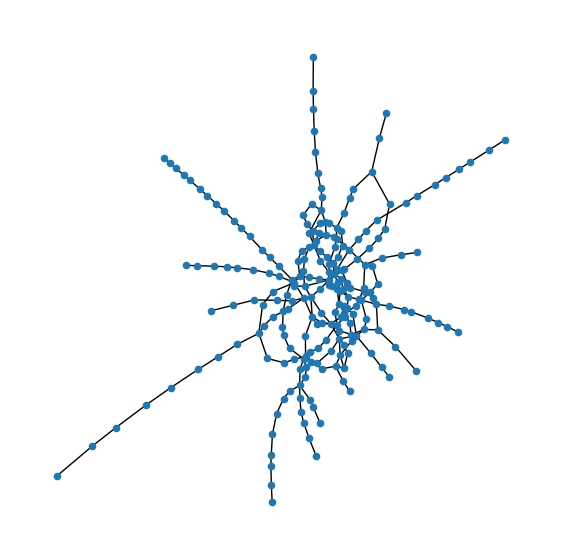

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
nx.draw_kamada_kawai(distances_G, with_labels=False, node_size=20)

## Analysis of distance travels

In [ ]:
distances_df["Shimo"]["Oji"]

0.0

In [ ]:
G = nx.Graph()
for i, row in distances_df.iterrows():
    for j, value in row.items():
        if value > 0: 
            G.add_edge(i, j, weight=value)
shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(G))
shortest_path_df = pd.DataFrame(shortest_path_lengths)
shortest_path_df

,Akabane-iwabuchi,Shimo,Akabanebashi,Azabu-juban,Daimon,Akasaka,Kokkai-gijidomae,Nogizaka,Akasaka-mitsuke,Aoyama-itchome,...,Toranomon Hills,Shin-kiba,Tatsumi,Shinjuku,Shinjuku-gyoemmae,Yotsuya-sanchome,Ueno-hirokoji,Toyosu,Ushigome-Yanagicho,Yoyogi-uehara
Akabane-iwabuchi,0.0,1.1,17.7,17.6,16.4,17.1,16.3,18.2,17.1,16.0,...,16.2,22.3,20.8,17.1,17.0,17.9,16.3,19.1,14.5,20.5
Shimo,1.1,0.0,16.6,16.5,15.3,16.0,15.2,17.1,16.0,14.9,...,15.1,21.2,19.7,16.0,15.9,16.8,15.2,18.0,13.4,19.4
Oji-kamiya,2.7,1.6,15.0,14.9,13.7,14.4,13.6,15.5,14.4,13.3,...,13.5,19.6,18.1,14.4,14.3,15.2,13.6,16.4,11.8,17.8
Oji,3.9,2.8,13.8,13.7,12.5,13.2,12.4,14.3,13.2,12.1,...,12.3,18.4,16.9,13.2,13.1,14.0,12.4,15.2,10.6,16.6
Nishigahara,4.9,3.8,12.8,12.7,11.5,12.2,11.4,13.3,12.2,11.1,...,11.3,17.4,15.9,12.2,12.1,13.0,11.4,14.2,9.6,15.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Chikatetsu-akatsuka,30.3,29.2,27.6,26.8,26.4,26.9,26.3,25.8,24.8,25.0,...,26.2,32.3,30.8,21.7,21.6,22.5,26.3,29.1,24.2,25.7
Baraki-nakayama,31.4,30.3,21.9,22.7,20.6,21.4,20.6,22.5,21.4,22.3,...,20.5,21.1,19.6,25.3,24.6,23.7,20.4,17.9,24.5,26.8
Chikatetsu-narimasu,33.1,32.0,30.4,29.6,29.2,29.7,29.1,28.6,27.6,27.8,...,29.0,35.1,33.6,24.5,24.4,25.3,29.1,31.9,27.0,28.5
Nishi-funabashi,33.3,32.2,23.8,24.6,22.5,23.3,22.5,24.4,23.3,24.2,...,22.4,23.0,21.5,27.2,26.5,25.6,22.3,19.8,26.4,28.7


In [ ]:
#This function is to prove we get the correct shortest path

def print_shortest_path(graph, source, target):
    path = nx.dijkstra_path(graph, source, target)
    path_length = nx.dijkstra_path_length(graph, source, target)
    print("Total path length:", path_length)
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        weight = graph[u][v]['weight']
        print(f"{u} -> {v}: {weight}")

print_shortest_path(G, 'Shimo', 'Oji')

Total path length: 2.8
Shimo -> Oji-kamiya: 1.6
Oji-kamiya -> Oji: 1.2


In [ ]:
def calculate_geographical_distance(station1, station2):
    coord1 = distances_G.nodes[station1]["coordinates"]
    coord2 = distances_G.nodes[station2]["coordinates"]
    return geodesic(coord1, coord2).kilometers

distance = calculate_geographical_distance("Tameiki-sanno", "Akasaka-mitsuke")
print(f"The distance between the two stations is {distance:.2f} kilometers")

The distance between the two stations is 0.72 kilometers


In [ ]:
def calculate_rail_distance_by_station(station1, station2):
     return distances_df[station1][station2]

dis = calculate_rail_distance_by_station("Tameiki-sanno","Akasaka-mitsuke")
print(dis)

0.9


In [ ]:
def calculate_rail_efficiency(station1, station2):
    rail_dis = calculate_rail_distance_by_station(station1, station2)
    geo_dis = calculate_geographical_distance(station1, station2)
    return rail_dis / geo_dis

In [ ]:
calculate_rail_efficiency("Tameiki-sanno","Akasaka-mitsuke")

1.2440321200830144

In [ ]:
def calculate_average_rail_efficiency():
    res = []
    for row_index, row in shortest_path_df.iterrows():
        for col_index, val in row.items():
            if val != 0:
                res.append(calculate_rail_efficiency(row_index,col_index))
    return statistics.mean(res)
calculate_average_rail_efficiency()

0.011535441516696837

Note: It looks like this function is only calculating the distance for stations that are directly connected to each other. But we should be calculating this over all stations that are connected. So if A-B-C we should also include the station pair (A,C) even though A and C aren't directly connected to each other. Try to use nx.shortest_path_length(distances_G,weight="weight") to get a dictionary of network distances for all possible station pairs instead  

  I already fixed it

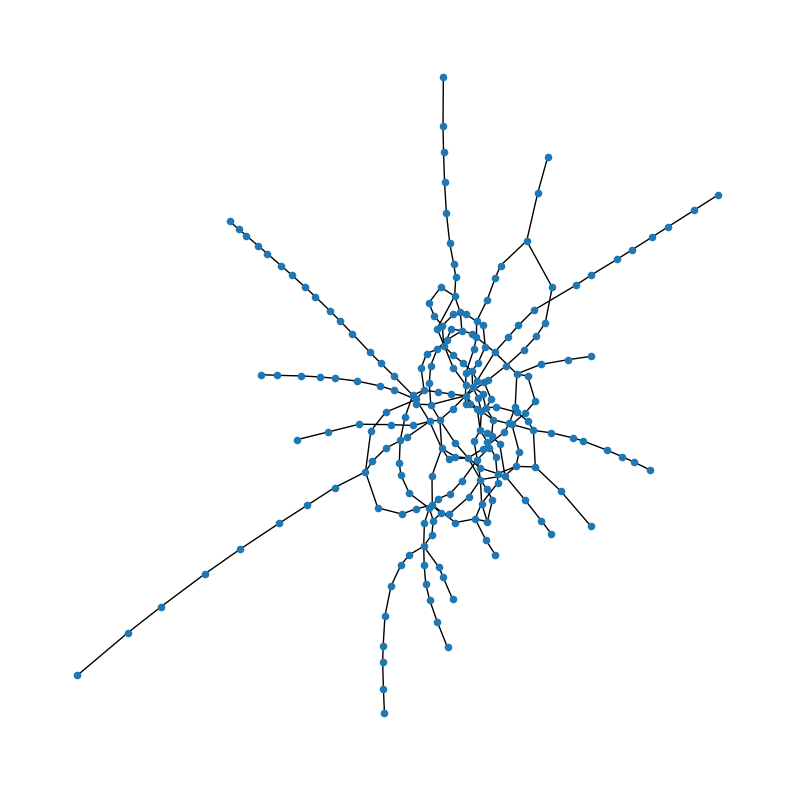

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
nx.draw_kamada_kawai(distances_G, with_labels=False, node_size=20)

## Network Statistics

In [ ]:
num_nodes = weights_G.number_of_nodes()
num_edges = weights_G.number_of_edges()

# calculate basic network statistics (avg degree, density, clustering, diameter)
avg_degree = np.mean([d for n, d in weights_G.degree()])
density = nx.density(weights_G)
degree_hist = nx.degree_histogram(weights_G)
avg_clustering = nx.average_clustering(weights_G)
diameter = nx.diameter(distances_G,weight="weight")

# computes average shortest path length
if nx.is_connected(distances_G):
    avg_shortest_path_length = nx.average_shortest_path_length(distances_G,weight="weight")
else:
    avg_shortest_path_length = "Graph is not connected"

# betweenness centrality
betweenness_centrality = nx.betweenness_centrality(weights_G)

# printing everything
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Average degree:", avg_degree)
print("Density:", density)
print("Degree distribution:", degree_hist)
print("Average clustering coefficient:", avg_clustering)
print("Diameter in km:", diameter)
print("Average shortest path length in km:", avg_shortest_path_length)
print("Betweenness centrality (top 5 nodes):\n")
for item in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(item)

Number of nodes: 223
Number of edges: 265
Average degree: 2.376681614349776
Average clustering coefficient: 0.0153462879920279
Diameter in km: 50.500000000000014
Average shortest path length in km: 11.927637054094443
Betweenness centrality (top 5 nodes):

('Otemachi', 0.3810619275320747)
('Kudanshita', 0.2412644633475394)
('Jimbocho', 0.2206488064875049)
('Shinjuku-sanchome', 0.19071899347937793)
('Ichigaya', 0.184768558086311)


## Calculating Core Scores 

In [ ]:
A=nx.adjacency_matrix(weights_G).todense()

# define objective function for optimization
# returns error from estimating A by CC^T
def objective(C):
    # C has to be flattened to make scipy work
    C=np.reshape(C,(-1,1))
    A_approx=C @ C.T
    return(np.linalg.norm(A-A_approx,'fro'))

# random guess for initial C
#init_C=np.random.choice([0,1],size=(A.shape[0],))
init_C=np.random.randint(2, size=A.shape[0])
optimized=scipy.optimize.minimize(objective,init_C,method='L-BFGS-B',bounds=[(0,1)]*A.shape[0])

# converts C into binary
best_C=(optimized.x>0.5).astype(int)




In [ ]:
# collect core station names
cstation_idx=[]
station_names=[]
for idx, val in enumerate(best_C):
    if val==1:
        cstation_idx.append(idx)

for i in cstation_idx:
    station_names.append(node_names[i])

print(station_names)

['Ginza', 'Hibiya', 'Higashi-ginza', 'Mitsukoshimae', 'Nihombashi', 'Otemachi']


## Node Dynamical Importance

In [ ]:
G_dir=weights_G.to_directed()

In [ ]:
print(nx.is_strongly_connected(G_dir),nx.is_directed(G_dir))

True True


In [ ]:
adj_matrix=nx.adjacency_matrix(G_dir)
e_val,right_vec=scipy.sparse.linalg.eigsh(adj_matrix,k=1,which='LA')
e_val,left_vec=scipy.sparse.linalg.eigsh(np.transpose(adj_matrix),k=1,which='LA')
denom=np.dot(np.transpose(left_vec),right_vec)[0][0]

In [ ]:
node_dynamical_importances=[]

for k in range(len(G_dir.nodes())):
    num=(left_vec[k]*right_vec[k])[0]
    node_dynamical_importances.append(num/denom)

In [ ]:
largest_node_di=pd.DataFrame(node_dynamical_importances).nlargest(10, 0)

largest_node_di.rename(columns={0:'Node Dynamical Importance'}, inplace=True)
largest_node_di['Station']=[list(G_dir.nodes())[idx] for idx in list(largest_node_di.index.values)]
largest_node_di.reset_index(drop=True,inplace=True)
largest_node_di=largest_node_di[["Station","Node Dynamical Importance"]]

In [ ]:
largest_node_di

,Station,Node Dynamical Importance
0,Ginza,0.208202
1,Hibiya,0.127664
2,Otemachi,0.117190
3,Nihombashi,0.107879
4,Higashi-ginza,0.097768
5,Mitsukoshimae,0.043811
6,Kyobashi,0.042339
7,Nijubashimae <Marunouchi>,0.033653
8,Kayabacho,0.033294
9,Tokyo,0.032709


## Node Percolation

In [ ]:
nx.average_shortest_path_length(distances_G,weight="weight")

11.927637054094443

In [ ]:
preserving_nodes=[]
mean_geod_dist=[]
for node in distances_G.nodes():
    distances_G_copy=distances_G.copy()
    distances_G_copy.remove_node(node)
    if nx.is_connected(distances_G_copy):
        geod_dist=nx.average_shortest_path_length(distances_G_copy,weight="weight")
        preserving_nodes.append(node)
        mean_geod_dist.append(geod_dist)

In [ ]:
largest_change=pd.DataFrame(mean_geod_dist).nlargest(10, 0)

largest_change.rename(columns={0:'Mean Geodesic Distance'}, inplace=True)
largest_change['Station']=[preserving_nodes[idx] for idx in list(largest_change.index.values)]
largest_change.reset_index(drop=True,inplace=True)
largest_change=largest_change[["Station","Mean Geodesic Distance"]]

In [ ]:
largest_change

,Station,Mean Geodesic Distance
0,Otemachi,12.966923
1,Shinjuku-sanchome,12.433048
2,Shin-ochanomizu,12.331165
3,Kudanshita,12.261110
4,Shinjuku-nishiguchi,12.240271
5,Hongo-sanchome,12.238034
6,Yushima,12.209694
7,Ueno,12.195695
8,Nagatacho,12.166487
9,Nihombashi,12.154356


In [ ]:
time_df=distances_df*30 #multiply data of distances between stations by avg metro speed
time_df

,Akabane-iwabuchi,Akabanebashi,Akasaka,Akasaka-mitsuke,Akebonobashi,Akihabara,Aoyama-itchome,Asakusa,Asakusabashi,Awajicho,...,Waseda,Yotasuya,Yotsuya,Yotsuya-sanchome,Yoyogi,Yoyogi-koen,Yoyogi-uehara,Yurakucho,Yushima,Zoshigaya
Akabane-iwabuchi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Akabanebashi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Akasaka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Akasaka-mitsuke,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,...,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Akebonobashi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yoyogi-koen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0
Yoyogi-uehara,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0
Yurakucho,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yushima,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Geocoding stops for QGIS

In [ ]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time


stops_df = pd.read_csv(r'/Users/georgeanders/Downloads/GFG')

# construct geocoder
geolocator = Nominatim(user_agent="metro_geocoder")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# iterate to geocode each stop
def get_coordinates(stop_name):
    try:
        location = geocode(f"{stop_name}, Tokyo, Japan")
        if location:
            return location.latitude, location.longitude
    except Exception as e:
        print(f"Error geocoding {stop_name}: {e}")
    return None, None

# create csv with geocoded stops
stops_df['latitude'], stops_df['longitude'] = zip(*stops_df['Station Name'].apply(get_coordinates))
stops_df = stops_df.dropna(subset=['latitude', 'longitude'])
stops_df.to_csv('tokyo_metro_stops_with_coordinates.csv', index=False)

## Gaster-Newman & Costs

In [ ]:
#Gaster-Newman Model: efficiency of entire network.
distances_G

b1 = 0.08  # avg wait time in hours ~5 minutes
b2 = nx.average_shortest_path_length(distances_G,weight="weight")/30 #avg travel time in hours 

L = nx.average_shortest_path_length(distances_G, weight=lambda u, v, d: b1 + b2 * d['weight'])

m = distances_G.number_of_edges()

alpha = 0.1  

cost = alpha * m + (1 - alpha) * L

print(cost)

31.541396516638034


In [ ]:
print(b2)
print(nx.average_shortest_path_length(distances_G,weight="weight"))

0.3975879018031481
11.927637054094443


In [ ]:
smallest_node_di=pd.DataFrame(node_dynamical_importances).nsmallest(10, 0)

smallest_node_di.rename(columns={0:'Node Dynamical Importance'}, inplace=True)
smallest_node_di['Station']=[list(G_dir.nodes())[idx] for idx in list(smallest_node_di.index.values)]
smallest_node_di.reset_index(drop=True,inplace=True)
smallest_node_di=smallest_node_di[["Station","Node Dynamical Importance"]]


In [ ]:
smallest_node_di

,Station,Node Dynamical Importance
0,Wakoshi,8.982529e-30
1,Nishi-takashimadaira,2.488530e-27
2,Chikatetsu-narimasu,5.166622e-27
3,Shin-takashimadaira,4.726687e-26
4,Takashimadaira,6.168006e-25
5,Chikatetsu-akatsuka,1.198199e-24
6,Nishi-funabashi,7.927971e-24
7,Hikarigaoka,9.772567e-24
8,Nishidai,1.574749e-23
9,Hasuna,2.778219e-22


In [ ]:
#values seem to correlate with node dynamical importance and the daily average stat websites on google doc
#CODE IS COST CHANGE AFTER REMOVING ONE NODE
def calculate_cost(G, b1, b2, alpha):
    b1 = 0.08
    b2 = nx.average_shortest_path_length(G,weight="weight")/30
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    m = G.number_of_edges()
    alpha = 0.1
    cost = alpha * m + (1 - alpha) * L
    return cost



initial_cost = calculate_cost(distances_G, b1, b2, alpha)
print("Initial Cost Value:", initial_cost)


costs_after_removed = {}

for node in distances_G.nodes(): #recalculate cost after removing a node
    G_removed = distances_G.copy()
    G_removed.remove_node(node)
    
    
    if nx.is_connected(G_removed):
        
        costprime = calculate_cost(G_removed, b1, b2, alpha)
        
       
        costs_after_removed[node] = costprime

#highest & lowest 10 values
costs_df = pd.DataFrame(costs_after_removed.items(), columns=['Node', 'Cost'])
sorted_costs_df = costs_df.sort_values(by='Cost', ascending=False)
print("\nlowest 10 values after removal:")
print(sorted_costs_df.tail(10))
print("\nhighest 10 values after removal:")
print(sorted_costs_df.head(10))



"""#printing stuff
print("Costs after removing:")
for node, cost in costs_after_removed.items():
    print( node, ":", cost)
"""


Initial Cost Value: 31.541396516638034

lowest 10 values after removal:
              Node       Cost
94       Shimbashi  31.227181
10     Azabu-juban  31.202186
38    Kasumigaseki  31.197890
84     Omote-sando  31.187659
24   Higashi-ginza  31.178164
22          Hibiya  31.158469
63       Nagatacho  31.133206
68      Nihombashi  31.128378
6   Aoyama-itchome  31.105500
15           Ginza  31.042167

highest 10 values after removal:
                 Node       Cost
96    Shin-ochanomizu  31.658457
133           Yushima  31.561849
4        Akebonobashi  31.497627
87           Otemachi  31.490004
109         Takebashi  31.488695
67               Nezu  31.482053
32              Iriya  31.460917
9            Awajicho  31.456527
80         Ochanomizu  31.448511
26   Higashi-shinjuku  31.448350


'#printing stuff\nprint("Costs after removing:")\nfor node, cost in costs_after_removed.items():\n    print( node, ":", cost)\n'

In [ ]:
print("Initial Cost Value:", initial_cost)
avg_cost_change = costs_df['Cost'].mean()
print("avg cost after removing important node:" , sorted_costs_df.tail(10)['Cost'].mean())
print("avg cost change when removing important node:" , initial_cost - sorted_costs_df.tail(10)['Cost'].mean())
print("avg cost after removing random node:" , avg_cost_change)
print("avg cost change when removing a random node:" , initial_cost - avg_cost_change)

Initial Cost Value: 31.541396516638034
avg cost after removing important node: 31.156079918980716
avg cost change when removing important node: 0.38531659765731874
avg cost after removing random node: 31.365576732000328
avg cost change when removing a random node: 0.17581978463770653


In [ ]:
#different code to remove 5 random nodes and recalculate cost scores.
#CODE IS COST CHANGE AFTER REMOVING 5 NODES

def calculate_cost(G, b1, b2, alpha):
    b1 = 0.08
    b2 = nx.average_shortest_path_length(G,weight="weight")/30
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    m = G.number_of_edges()
    alpha = 0.1
    cost = alpha * m + (1 - alpha) * L
    return cost

initial_cost = calculate_cost(distances_G, b1, b2, alpha)
print("Initial Cost Value:", initial_cost)


connected = False
while not connected:
    #Randomly removes 5 nodes. If it disconnects graph, will pick a new one
    random_nodes = random.sample(list(distances_G.nodes()), 5)
    

    
    G_removed = distances_G.copy()
    G_removed.remove_nodes_from(random_nodes)

    
    if nx.is_connected(G_removed):
        connected = True
        cost_after_removal = calculate_cost(G_removed, b1, b2, alpha)
        print("Randomly selected nodes to remove:", random_nodes)
        print("Cost after removing the 5 random nodes:", cost_after_removal)
   

# Calculate the new avg cost value
if connected:
    costs_after_removed = {tuple(random_nodes): cost_after_removal}
    new_average_cost = sum(costs_after_removed.values()) / len(costs_after_removed)
    print("New avg cost after removal:", new_average_cost)

Initial Cost Value: 31.541396516638034
Randomly selected nodes to remove: ['Takebashi', 'Kayabacho', 'Tawaramachi', 'Hongo-sanchome', 'Myogadani']
Cost after removing the 5 random nodes: 30.86946915498068
New avg cost after removal: 30.86946915498068


In [ ]:
#avg recalculated score after removing 5 random nodes (assuming it doesnt break the network)
#CODE IS AVERAGE COST CHANGE AFTER REMOVING 5 RANDOM NODES
#NOT ACTUALLY A HARD AVERAGE, JUST RUNS A BUNCH OF TESTS AND CALCULATES AVERAGE
def calculate_cost(G, b1, b2, alpha):
    b1 = 0.08
    b2 = nx.average_shortest_path_length(G,weight="weight") / 30
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    m = G.number_of_edges()
    alpha = 0.1
    cost = alpha * m + (1 - alpha) * L
    return cost

initial_cost = calculate_cost(distances_G, b1, b2, alpha)
print("Initial Cost Value:", initial_cost)

num_iterations = 10  #calculating 'however many' times to find the average change after removing 5 random nodes
costs_after_removal_list = []

for _ in range(num_iterations):
    connected = False
    while not connected:
        random_nodes = random.sample(list(distances_G.nodes()), 5)

        G_removed = distances_G.copy()
        G_removed.remove_nodes_from(random_nodes)

        if nx.is_connected(G_removed):
            connected = True
            cost_after_removal = calculate_cost(G_removed, b1, b2, alpha)
            print("Cost after removing the 5 random nodes:", cost_after_removal)
            costs_after_removal_list.append(cost_after_removal)
        

# Calculate the new average cost value over all iterations
if costs_after_removal_list:
    new_average_cost = sum(costs_after_removal_list) / len(costs_after_removal_list)
    print("New average cost after removal:", new_average_cost)
else:
    print("No connected graphs were found after node removals.")

Initial Cost Value: 31.541396516638034
Cost after removing the 5 random nodes: 30.6712868450134
Cost after removing the 5 random nodes: 30.665350548691656
Cost after removing the 5 random nodes: 30.7784597786453
Cost after removing the 5 random nodes: 30.83773564148801
Cost after removing the 5 random nodes: 30.75521738822285
Cost after removing the 5 random nodes: 30.830158491355245
Cost after removing the 5 random nodes: 30.76901002898866
Cost after removing the 5 random nodes: 30.778858363619342
Cost after removing the 5 random nodes: 30.94227854320217
Cost after removing the 5 random nodes: 31.074866972078127
New average cost after removal: 30.810322260130476


In [ ]:
#calculating  local efficiency (assumed as mean geodesic distance) changes with percolation
#code is basically cost function altered for L, since the L in the cost function was
#mean geodesic distance between nodes using Tij for distance
#CODE IS MEAN GEODESIC DIST AFTER REMOVING ONE NODE (LOCAL EFFICIENCY)
def calculate_average_shortest_path_length(G, b1, b2):
    b1 = 0.08
    b2 = nx.average_shortest_path_length(G,weight="weight") / 30
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    return L


initial_L = calculate_average_shortest_path_length(distances_G, b1=None, b2=None)
print("Initial Average Shortest Path Length (L):", initial_L)

L_after_removed = {}

for node in distances_G.nodes():  # Recalculate L after removing a node
    G_removed = distances_G.copy()
    G_removed.remove_node(node)
    
    if nx.is_connected(G_removed):
        L_prime = calculate_average_shortest_path_length(G_removed, b1=None, b2=None)
        L_after_removed[node] = L_prime


L_df = pd.DataFrame(L_after_removed.items(), columns=['Node', 'Average Shortest Path Length'])


sorted_L_df = L_df.sort_values(by='Average Shortest Path Length', ascending=False)
print("\nHighest 10 values (Average Shortest Path Length):")
print(sorted_L_df.head(10))
print("\nLowest 10 values (Average Shortest Path Length):")
print(sorted_L_df.tail(10))

Initial Average Shortest Path Length (L): 5.601551685153371

Highest 10 values (Average Shortest Path Length):
                    Node  Average Shortest Path Length
87              Otemachi                      6.544449
102    Shinjuku-sanchome                      6.049191
96       Shin-ochanomizu                      5.953841
51            Kudanshita                      5.901233
28        Hongo-sanchome                      5.871073
101  Shinjuku-nishiguchi                      5.869107
133              Yushima                      5.846499
120                 Ueno                      5.823180
63             Nagatacho                      5.814674
30              Ichigaya                      5.809510

Lowest 10 values (Average Shortest Path Length):
                     Node  Average Shortest Path Length
66                 Nakano                      5.573490
82                Ogikubo                      5.564853
72           Nishi-magome                      5.556473
0        A

In [ ]:
#avg local eff after removing a random node is avg change in efficiency
avg_L_change = L_df['Average Shortest Path Length'].mean()
print("avg local eff after removing random node:" , avg_L_change)

print("avg eff after removing important node:" , sorted_L_df.tail(10)['Average Shortest Path Length'].mean())
print("avg eff change when removing important node:" , initial_L - sorted_L_df.tail(10)['Average Shortest Path Length'].mean())

avg local eff after removing random node: 5.67615521662588
avg eff after removing important node: 5.531019929882621
avg eff change when removing important node: 0.07053175527074984


In [ ]:
#LOOP REMOVAL 5 NODES
def calculate_average_shortest_path_length(G, b1, b2):
    b1 = 0.183
    b2 = nx.average_shortest_path_length(G, weight="weight") / 32
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    return L


initial_L = calculate_average_shortest_path_length(distances_G, b1=None, b2=None)
print("Initial Average Shortest Path Length (L):", initial_L)

num_iterations = 10  
L_changes = []
L_values_after_removal = []

for _ in range(num_iterations):
    connected = False
    while not connected:
        G_temp = distances_G.copy()
        
        # Randomly remove 5 nodes
        random_nodes = random.sample(list(G_temp.nodes()), 5)
        G_temp.remove_nodes_from(random_nodes)

        if nx.is_connected(G_temp):
            connected = True
            L_prime = calculate_average_shortest_path_length(G_temp, b1=None, b2=None)
            L_changes.append(L_prime - initial_L)
            L_values_after_removal.append(L_prime)
            print(f"Average Shortest Path Length after removing nodes {random_nodes}: {L_prime}")

# Calculate the average change in L across all iterations
if L_changes:
    average_change_L = sum(L_changes) / len(L_changes)
    average_L_after_removal = sum(L_values_after_removal) / len(L_values_after_removal)
    print(f"Average change in Average Shortest Path Length after {num_iterations} iterations: {average_change_L}")
    print(f"Average value of Average Shortest Path Length after {num_iterations} iterations: {average_L_after_removal}")
else:
    print(f"No changes in Average Shortest Path Length were detected after {num_iterations} iterations.")

Initial Average Shortest Path Length (L): 6.402562798221236
Average Shortest Path Length after removing nodes ['Azabu-juban', 'Nishi-takashimadaira', 'Akihabara', 'Uchisaiwaicho', 'Kita-ayase']: 6.426167284595991
Average Shortest Path Length after removing nodes ['Tokyo', 'Kita-sando', 'Yushima', 'Shin-otsuka', 'Shinjuku']: 6.855915157455283
Average Shortest Path Length after removing nodes ['Ushigome-Yanagicho', 'Hikarigaoka', 'Sakuradamon', 'Akihabara', 'Hanzomon']: 6.579885690018854
Average Shortest Path Length after removing nodes ['Kyobashi', 'Kayabacho', 'Nishi-nippori', 'Gokokuji', 'Kiyosumi-shirakawa']: 6.797616652363678
Average Shortest Path Length after removing nodes ['Yoyogi', 'Akihabara', 'Nishi-funabashi', 'Nezu', 'Lidabashi']: 6.650353556429359
Average Shortest Path Length after removing nodes ['Nagatacho', 'Higashi-shinjuku', 'Shinjuku-sanchome', 'Yoyogi-uehara', 'Kokki-gijidomae']: 7.259751000292493
Average Shortest Path Length after removing nodes ['Sakuradamon', 'Yur

## Global Efficiency

In [ ]:
#code ran very slowly so I used chat gpt to make one that ran the same but was more efficient
#CODE CALCULATES GLOBAL EFFICIENCY (SLOW) AND G.E. CHANGE AFTER REMOVING ONE NODE
#CAN POTENTIALLY IGNORE THIS CODE BUT IM KEEPING IT HERE CUZ IT WORKS ITS JUST REALLY SLOW

def global_efficiency(G):
    n = len(G)
    inv_shortest_paths = 0
    for u in G:
        for v in G:
            if u != v:
                try:
                    inv_shortest_paths += 1 / nx.shortest_path_length(G, u, v, weight='weight')
                except nx.NetworkXNoPath:
                    inv_shortest_paths += 0
    return inv_shortest_paths / (n * (n - 1))


initial_global_efficiency = global_efficiency(distances_G)
print("Initial Global Efficiency:", initial_global_efficiency)

efficiencies_after_removed = {}

for node in distances_G.nodes():  # recalculate efficiency after removing a node
    G_removed = distances_G.copy()
    G_removed.remove_node(node)
    
    if nx.is_connected(G_removed):
        costprime = calculate_cost(G_removed, b1, b2, alpha)
        efficiency_prime = global_efficiency(G_removed)
        
        costs_after_removed[node] = costprime
        efficiencies_after_removed[node] = efficiency_prime

efficiencies_df = pd.DataFrame(efficiencies_after_removed.items(), columns=['Node', 'Global Efficiency'])


sorted_efficiencies_df = efficiencies_df.sort_values(by='Global Efficiency', ascending=False)
print("\nHighest 10 values (Global Efficiency):")
print(sorted_efficiencies_df.head(10))
print("\nLowest 10 values (Global Efficiency):")
print(sorted_efficiencies_df.tail(10))


Initial Global Efficiency: 0.12829482412474838


KeyboardInterrupt: 

In [ ]:
#MORE EFFICIENT FORM OF THE CODE DIRECTLY ABOVE SOURCED FROM CHATGPT
#CODE CALCULATES GLOBAL EFFICIENCY (FASTER) AND G.E. CHANGE AFTER REMOVING ONE NODE
def global_efficiency(G, shortest_path_lengths):
    n = len(G)
    inv_shortest_paths = 0
    for u in G:
        for v in G:
            if u != v:
                try:
                    inv_shortest_paths += 1 / shortest_path_lengths[u][v]
                except KeyError:
                    inv_shortest_paths += 0
    return inv_shortest_paths / (n * (n - 1))

# Precompute shortest path lengths for the original graph
shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(distances_G))

initial_global_efficiency = global_efficiency(distances_G, shortest_path_lengths)
print("Initial Global Efficiency:", initial_global_efficiency)

efficiencies_after_removed = {}

for node in distances_G.nodes():  # Recalculate eff after removing a node
    G_removed = distances_G.copy()
    G_removed.remove_node(node)
    
    if nx.is_connected(G_removed):
        # Precompute shortest path lengths for the modified graph
        shortest_path_lengths_removed = dict(nx.all_pairs_dijkstra_path_length(G_removed))
        efficiency_prime = global_efficiency(G_removed, shortest_path_lengths_removed)
        efficiencies_after_removed[node] = efficiency_prime


efficiencies_df = pd.DataFrame(efficiencies_after_removed.items(), columns=['Node', 'Global Efficiency'])


sorted_efficiencies_df = efficiencies_df.sort_values(by='Global Efficiency', ascending=False)
print("\nHighest 10 values (Global Efficiency):")
print(sorted_efficiencies_df.head(10))
print("\nLowest 10 values (Global Efficiency):")
print(sorted_efficiencies_df.tail(10))

Initial Global Efficiency: 0.12829482412474838

Highest 10 values (Global Efficiency):
                     Node  Global Efficiency
126               Wakoshi           0.129164
71        Nishi-funabashi           0.129044
61             Motoyawata           0.129009
27            Hikarigaoka           0.128938
42             Kita-ayase           0.128934
76   Nishi-takashimadaira           0.128924
0        Akabane-iwabuchi           0.128860
72           Nishi-magome           0.128838
66                 Nakano           0.128813
82                Ogikubo           0.128801

Lowest 10 values (Global Efficiency):
                  Node  Global Efficiency
6       Aoyama-itchome           0.125449
63           Nagatacho           0.125393
59       Mitsukoshimae           0.125345
28      Hongo-sanchome           0.125324
15               Ginza           0.125225
38        Kasumigaseki           0.125152
51          Kudanshita           0.124873
68          Nihombashi           0.124632
1

In [ ]:
#avg global eff after removing a random node is avg change in efficiency
avg_eff_change = efficiencies_df['Global Efficiency'].mean()
print("avg eff after removing random node:" , avg_eff_change)

print("avg eff after removing important node:" , sorted_efficiencies_df.tail(10)['Global Efficiency'].mean())
print("avg eff change when removing important node:" , initial_global_efficiency - sorted_efficiencies_df.tail(10)['Global Efficiency'].mean())

avg eff after removing random node: 0.12741698609945357
avg eff after removing important node: 0.12445306581974373
avg eff change when removing important node: 0.003841758305004647


In [ ]:
#CODE IS REMOVING ONE RANDOM NODES AND CHANGE IN EFFICIENCY
def global_efficiency(G, shortest_path_lengths):
    n = len(G)
    inv_shortest_paths = 0
    for u in G:
        for v in G:
            if u != v:
                try:
                    inv_shortest_paths += 1 / shortest_path_lengths[u][v]
                except KeyError:
                    inv_shortest_paths += 0
    return inv_shortest_paths / (n * (n - 1))

# Precompute shortest path lengths for the original graph
shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(distances_G))

initial_global_efficiency = global_efficiency(distances_G, shortest_path_lengths)
print("Initial Global Efficiency:", initial_global_efficiency)

connected = False
while not connected:
    # Randomly remove 1 node. If it disconnects graph, will pick a new one
    random_node = random.choice(list(distances_G.nodes()))

    G_removed = distances_G.copy()
    G_removed.remove_node(random_node)
    

    if nx.is_connected(G_removed):
        connected = True
        # Precompute shortest path lengths for the modified graph
        shortest_path_lengths_removed = dict(nx.all_pairs_dijkstra_path_length(G_removed))
        # Calculate global eff after removal
        efficiency_after_removal = global_efficiency(G_removed, shortest_path_lengths_removed)
        print("Randomly selected node to remove:", random_node)
        print("Global Efficiency after removing the random node:", efficiency_after_removal)
  

if connected:
    efficiencies_after_removed = {random_node: efficiency_after_removal}
    new_average_efficiency = sum(efficiencies_after_removed.values()) / len(efficiencies_after_removed)
    print("New avg global efficiency after removal:", new_average_efficiency)

Initial Global Efficiency: 0.12829482412474838
Randomly selected node to remove: Yoyogi-uehara
Global Efficiency after removing the random node: 0.12852037825528587
New avg global efficiency after removal: 0.12852037825528587


In [ ]:
#CODE IS REMOVING 5 RANDOM NODES AND CHANGE IN EFFICIENCY
def global_efficiency(G, shortest_path_lengths):
    n = len(G)
    inv_shortest_paths = 0
    for u in G:
        for v in G:
            if u != v:
                try:
                    inv_shortest_paths += 1 / shortest_path_lengths[u][v]
                except KeyError:
                    inv_shortest_paths += 0
    return inv_shortest_paths / (n * (n - 1))

# Precompute shortest path lengths for the original graph
shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(distances_G))

initial_global_efficiency = global_efficiency(distances_G, shortest_path_lengths)
print("Initial Global Efficiency:", initial_global_efficiency)

connected = False
while not connected:
    # Randomly remove 5 nodes. If it disconnects graph, will pick a new one
    random_nodes = random.sample(list(distances_G.nodes()), 5)
   
    
    
    G_removed = distances_G.copy()
    G_removed.remove_nodes_from(random_nodes)
    
   
    if nx.is_connected(G_removed):
        connected = True
        # Precompute shortest path lengths for the modified graph
        shortest_path_lengths_removed = dict(nx.all_pairs_dijkstra_path_length(G_removed))
        # Calculate global efficiency after removal
        efficiency_after_removal = global_efficiency(G_removed, shortest_path_lengths_removed)
        print("Randomly selected nodes to remove:", random_nodes)
        print("Global Efficiency after removing the 5 random nodes:", efficiency_after_removal)


if connected:
    efficiencies_after_removed = {tuple(random_nodes): efficiency_after_removal}
    new_average_efficiency = sum(efficiencies_after_removed.values()) / len(efficiencies_after_removed)
    print("New avg global efficiency after removal:", new_average_efficiency)

    initial_cost = calculate_cost(distances_G, b1, b2, alpha)
print("Initial Cost Value:", initial_cost)


Initial Global Efficiency: 0.12829482412474838
Randomly selected nodes to remove: ['Takaracho', 'Kita-ayase', 'Machiya', 'Naka-okachimachi', 'Nihombashi']
Global Efficiency after removing the 5 random nodes: 0.12479434651310176
New avg global efficiency after removal: 0.12479434651310176
Initial Cost Value: 31.541396516638034


In [ ]:
#LOOPING THE CODE IS REMOVING 5 RANDOM NODES AND CHANGE IN EFFICIENCY
def global_efficiency(G, shortest_path_lengths):
    n = len(G)
    inv_shortest_paths = 0
    for u in G:
        for v in G:
            if u != v:
                try:
                    inv_shortest_paths += 1 / shortest_path_lengths[u][v]
                except KeyError:
                    inv_shortest_paths += 0
    return inv_shortest_paths / (n * (n - 1))

# Cost function
def calculate_cost(G, b1, b2, alpha):
    b1 = 0.08
    b2 = nx.average_shortest_path_length(G, weight="weight") / 30
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    m = G.number_of_edges()
    alpha = 0.5
    cost = alpha * m + (1 - alpha) * L
    return cost

# Initial global efficiency
    initial_global_efficiency = global_efficiency(distances_G, shortest_path_lengths)
    print("Initial Global Efficiency:", initial_global_efficiency)

num_iterations = 100  
efficiencies_after_removal_list = []



# Looping
for _ in range(num_iterations):
    # Precompute shortest path lengths for the original graph
    shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(distances_G))

    

    connected = False
    while not connected:
        # Randomly remove 5 nodes
        random_nodes = random.sample(list(distances_G.nodes()), 5)
        G_removed = distances_G.copy()
        G_removed.remove_nodes_from(random_nodes)

        if nx.is_connected(G_removed):
            connected = True
            # Precompute shortest path lengths for the modified graph
            shortest_path_lengths_removed = dict(nx.all_pairs_dijkstra_path_length(G_removed))
            # Calculate global eff after removal
            efficiency_after_removal = global_efficiency(G_removed, shortest_path_lengths_removed)
            efficiencies_after_removal_list.append(efficiency_after_removal)
            print("Global Efficiency after removing the 5 random nodes:", efficiency_after_removal)

# Calculate the new avg globla eff value over all iterations
if efficiencies_after_removal_list:
    new_average_efficiency = sum(efficiencies_after_removal_list) / len(efficiencies_after_removal_list)
    print("New average global efficiency after removal:", new_average_efficiency)
else:
    print("No connected graphs were found after node removals.")

Global Efficiency after removing the 5 random nodes: 0.12298024647017147
Global Efficiency after removing the 5 random nodes: 0.12406795014480053
Global Efficiency after removing the 5 random nodes: 0.12451899763221579
Global Efficiency after removing the 5 random nodes: 0.12662488202651576
Global Efficiency after removing the 5 random nodes: 0.12469796995842126
Global Efficiency after removing the 5 random nodes: 0.12392163751771708
Global Efficiency after removing the 5 random nodes: 0.12307452572498309
Global Efficiency after removing the 5 random nodes: 0.12368347461705541
Global Efficiency after removing the 5 random nodes: 0.12524133484775807
Global Efficiency after removing the 5 random nodes: 0.12682685612158
Global Efficiency after removing the 5 random nodes: 0.11989799838946022
Global Efficiency after removing the 5 random nodes: 0.12508204511419208
Global Efficiency after removing the 5 random nodes: 0.12293891472433567
Global Efficiency after removing the 5 random nodes: 0

## Discussion of Important Nodes (Robustness Analysis)

Nodes with highest betweeness centrality:

('Otemachi', 0.3810619275320747)
('Kudanshita', 0.2412644633475394)
('Jimbocho', 0.2206488064875049)
('Shinjuku-sanchome', 0.19071899347937793)
('Ichigaya', 0.184768558086311)


Nodes with the highest dynamical importance:
(i.e, when this station is closed, how does this affect the system?)

(Ginza, 0.2082015493)
(Hibiya, 0.1276639413)
(Otemachi, 0.1171899988)
(Nihombashi, 0.1078786536)
(Higashi-ginza, 0.09776780064)

Nodes in the core of the network (calculate from core-periphery structures):

('Ginza', 'Hibiya', 'Higashi-ginza', 'Mitsukoshimae', 'Nihombashi', 'Otemachi')

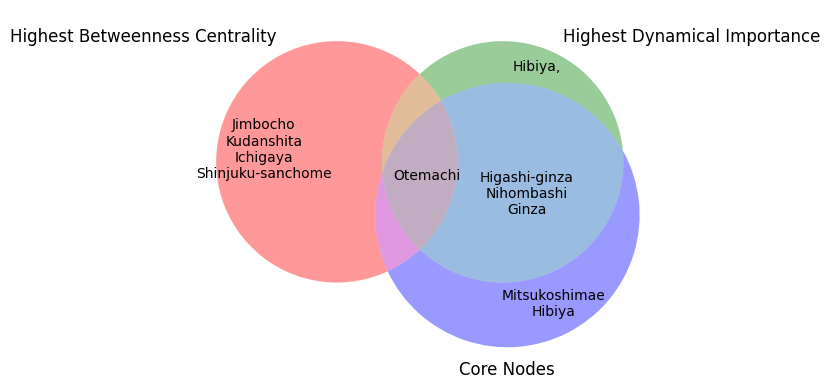

In [ ]:
# creating venn diagram for important nodes + measurements
from matplotlib_venn import venn3
top_BC={'Otemachi','Kudanshita','Jimbocho','Shinjuku-sanchome','Ichigaya'}
top_DN={'Ginza','Hibiya,','Otemachi', 'Nihombashi','Higashi-ginza'}
core_nodes={'Ginza', 'Hibiya', 'Higashi-ginza', 'Mitsukoshimae', 'Nihombashi', 'Otemachi'}

categories = {
    'Highest Betweenness Centrality': top_BC,
    'Highest Dynamical Importance': top_DN,
    'Core Nodes': core_nodes
}
v=venn3([top_BC,top_DN,core_nodes],categories)

def set_label(subset, value):
    v.get_label_by_id(subset).set_text('\n'.join(value))

# setting the labels for each subset
set_label('100', top_BC - top_DN - core_nodes)
set_label('010', top_DN - top_BC - core_nodes)
set_label('001', core_nodes - top_BC - top_DN)
set_label('110', top_BC & top_DN - core_nodes)
set_label('101', top_BC & core_nodes - top_DN)
set_label('011', top_DN & core_nodes - top_BC)
set_label('111', top_BC & top_DN & core_nodes)



plt.show()

# Madrid Metro 

Found metro data for Madrid  (I was originally trying to find Los Angeles metro data but it was too difficult :/ ). I was able to find weights, distances, seconds elapsed, and coordinates so hopefully that simplifies some of the calculations

Madrid Metro Data Github

## Set up

In [ ]:
df_1=pd.read_csv("metro_edges_no_duplicated_edges_no_cycles_speed_networkx.csv")
df_1["distance_km"]=df_1["distance_meters"]/1000
df_1=df_1[["Source","Target","distance_km","travel_seconds"]]

df_2=pd.read_csv("metro_gephi_nodes_coordinates.csv")

In [ ]:
df_2

,Label,Id,longitude,latitude
0,VILLAVERDE ALTO,273,-3.71199,40.34123
1,AEROPUERTO T4,285,-3.59325,40.49177
2,PLAZA DE CASTILLA,1,-3.68917,40.46690
3,RETIRO,32,-3.68624,40.42031
4,ALVARADO,5,-3.70331,40.45033
...,...,...,...,...
236,CONGOSTO,27,-3.61884,40.37238
237,HOSPITAL DEL HENARES,296,-3.53453,40.41761
238,O'DONNELL,115,-3.66860,40.42289
239,LEGANES CENTRAL,235,-3.77154,40.32899


In [ ]:
[df_2['Label']]
    

[0           VILLAVERDE ALTO
 1             AEROPUERTO T4
 2         PLAZA DE CASTILLA
 3                    RETIRO
 4                  ALVARADO
                ...         
 236                CONGOSTO
 237    HOSPITAL DEL HENARES
 238               O'DONNELL
 239         LEGANES CENTRAL
 240       ALONSO DE MENDOZA
 Name: Label, Length: 241, dtype: object]

In [ ]:
# field names 
import csv
fields = ['Name'] 
   
# data rows of csv file 

rows = [df_2['Label']]
with open('GFG', 'w') as f:
     
    # using csv.writer method from CSV package
    write = csv.writer(f)
     
    write.writerow(fields)
    write.writerows(rows)

In [ ]:
distances_G=nx.Graph()
weights_G=nx.Graph()

In [ ]:
for i in range(len(df_1)):
  distances_G.add_edge(df_1["Source"][i],df_1["Target"][i],weight=df_1["distance_km"][i],seconds=df_1["travel_seconds"][i])
  weights_G.add_edge(df_1["Source"][i],df_1["Target"][i],weight=1/df_1["distance_km"][i],seconds=df_1["travel_seconds"][i])

In [ ]:
for i in range(len(df_2)):
  distances_G.add_node(df_2["Id"][i], coordinates=[df_2["latitude"][i],df_2["longitude"][i]])
  weights_G.add_node(df_2["Id"][i], coordinates=[df_2["latitude"][i],df_2["longitude"][i]])

In [ ]:
nx.relabel_nodes(distances_G,dict(zip(df_2["Id"],df_2["Label"])),copy=False)
nx.relabel_nodes(weights_G,dict(zip(df_2["Id"],df_2["Label"])),copy=False)

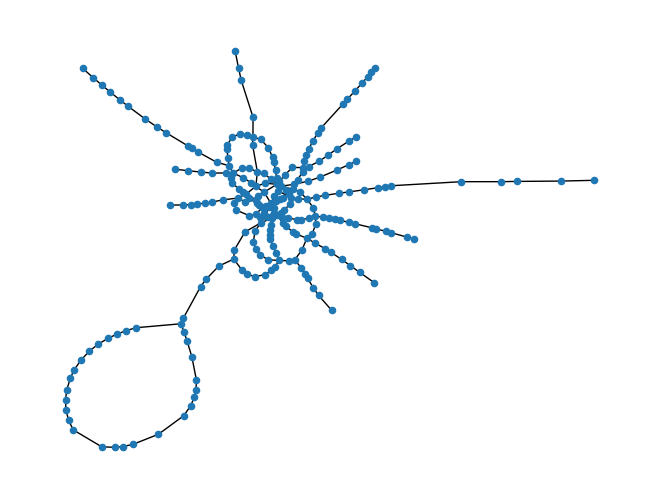

In [ ]:
nx.draw_kamada_kawai(distances_G,with_labels=False,node_size=20)

## Analysis of Distance Travels

In [ ]:
for u, attr in distances_G.nodes(data=True):
    print(f"Edge from {u}  has attributes: {attr}")

Edge from SAN BERNARDO  has attributes: {'coordinates': [40.43001, -3.70557]}
Edge from NOVICIADO  has attributes: {'coordinates': [40.42484, -3.70742]}
Edge from LA POVEDA  has attributes: {'coordinates': [40.31902, -3.47745]}
Edge from ARGANDA DEL REY  has attributes: {'coordinates': [40.30367, -3.44752]}
Edge from PARQUE LISBOA  has attributes: {'coordinates': [40.34969, -3.8212]}
Edge from PUERTA DEL SUR  has attributes: {'coordinates': [40.34524, -3.81211]}
Edge from UNIVERSIDAD REY JUAN CARLOS  has attributes: {'coordinates': [40.33512, -3.87218]}
Edge from MOSTOLES CENTRAL  has attributes: {'coordinates': [40.3285, -3.86354]}
Edge from CASA DE CAMPO  has attributes: {'coordinates': [40.40324, -3.76101]}
Edge from COLONIA JARDIN  has attributes: {'coordinates': [40.39698, -3.77462]}
Edge from PARQUE DE SANTA MARIA  has attributes: {'coordinates': [40.47711, -3.64524]}
Edge from SAN LORENZO  has attributes: {'coordinates': [40.47447, -3.63958]}
Edge from MONTECARMELO  has attribut

In [ ]:
distances_G.edges

EdgeView([('SAN BERNARDO', 'NOVICIADO'), ('SAN BERNARDO', 'ARGÜELLES'), ('SAN BERNARDO', 'QUEVEDO'), ('SAN BERNARDO', 'BILBAO'), ('NOVICIADO', 'SANTO DOMINGO'), ('LA POVEDA', 'ARGANDA DEL REY'), ('LA POVEDA', 'RIVAS VACIAMADRID'), ('PARQUE LISBOA', 'PUERTA DEL SUR'), ('PARQUE LISBOA', 'ALCORCON CENTRAL'), ('PUERTA DEL SUR', 'SAN NICASIO'), ('PUERTA DEL SUR', 'JOAQUIN VILUMBRALES'), ('UNIVERSIDAD REY JUAN CARLOS', 'MOSTOLES CENTRAL'), ('UNIVERSIDAD REY JUAN CARLOS', 'PARQUE OESTE'), ('MOSTOLES CENTRAL', 'PRADILLO'), ('CASA DE CAMPO', 'COLONIA JARDIN'), ('CASA DE CAMPO', 'BATAN'), ('CASA DE CAMPO', 'CAMPAMENTO'), ('COLONIA JARDIN', 'AVIACION ESPAÑOLA'), ('PARQUE DE SANTA MARIA', 'SAN LORENZO'), ('PARQUE DE SANTA MARIA', 'HORTALEZA'), ('SAN LORENZO', 'MAR DE CRISTAL'), ('MONTECARMELO', 'LAS TABLAS'), ('MONTECARMELO', 'TRES OLIVOS'), ('LAS TABLAS', 'RONDA DE LA COMUNICACION'), ('HENARES', 'HOSPITAL DEL HENARES'), ('HENARES', 'JARAMA'), ('MONCLOA', 'ARGÜELLES'), ('MONCLOA', 'CIUDAD UNIVERSI

In [ ]:
for i in range(len(df_2)):
  distances_G.add_node(df_2["Id"][i], coordinates=[df_2["latitude"][i],df_2["longitude"][i]])
  weights_G.add_node(df_2["Id"][i], coordinates=[df_2["latitude"][i],df_2["longitude"][i]])

In [ ]:
for u, v, attr in distances_G.edges(data=True):
    print(f"Edge from {u} to {v} has attributes: {attr}")

Edge from SAN BERNARDO to NOVICIADO has attributes: {'weight': 0.5951695167213639, 'seconds': 247.0}
Edge from SAN BERNARDO to ARGÜELLES has attributes: {'weight': 0.8845970328506447, 'seconds': 283.0}
Edge from SAN BERNARDO to QUEVEDO has attributes: {'weight': 0.3716531023171588, 'seconds': 191.0}
Edge from SAN BERNARDO to BILBAO has attributes: {'weight': 0.306395820330725, 'seconds': 213.0}
Edge from NOVICIADO to SANTO DOMINGO has attributes: {'weight': 0.3935478322180161, 'seconds': 204.0}
Edge from LA POVEDA to ARGANDA DEL REY has attributes: {'weight': 3.0623757203955804, 'seconds': 533.0}
Edge from LA POVEDA to RIVAS VACIAMADRID has attributes: {'weight': 3.8114197174857294, 'seconds': 573.0}
Edge from PARQUE LISBOA to PUERTA DEL SUR has attributes: {'weight': 0.916835268280572, 'seconds': 317.0}
Edge from PARQUE LISBOA to ALCORCON CENTRAL has attributes: {'weight': 0.8998815530732983, 'seconds': 347.0}
Edge from PUERTA DEL SUR to SAN NICASIO has attributes: {'weight': 3.240105

In [ ]:
nx.relabel_nodes(distances_G,dict(zip(df_2["Id"],df_2["Label"])),copy=False)
nx.relabel_nodes(weights_G,dict(zip(df_2["Id"],df_2["Label"])),copy=False)

In [ ]:
distances_df = nx.to_pandas_adjacency(distances_G, weight='weight')

distances_df

,SAN BERNARDO,NOVICIADO,LA POVEDA,ARGANDA DEL REY,PARQUE LISBOA,PUERTA DEL SUR,UNIVERSIDAD REY JUAN CARLOS,MOSTOLES CENTRAL,CASA DE CAMPO,COLONIA JARDIN,...,RIVAS FUTURA,PORTAZGO,RIVAS VACIAMADRID,AEROPUERTO T4,BARAJAS,ISLAS FILIPINAS,VALDECARROS,VELAZQUEZ,MIGUEL HERNANDEZ,PITIS
SAN BERNARDO,0.00000,0.59517,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NOVICIADO,0.59517,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LA POVEDA,0.00000,0.00000,0.000000,3.062376,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,3.81142,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ARGANDA DEL REY,0.00000,0.00000,3.062376,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PARQUE LISBOA,0.00000,0.00000,0.000000,0.000000,0.0,0.916835,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ISLAS FILIPINAS,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VALDECARROS,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VELAZQUEZ,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIGUEL HERNANDEZ,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
G = nx.Graph()
for i, row in distances_df.iterrows():
    for j, value in row.items():
        if value > 0: 
            G.add_edge(i, j, weight=value)
shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(G))
shortest_path_df = pd.DataFrame(shortest_path_lengths)
shortest_path_df

,SAN BERNARDO,NOVICIADO,ARGÜELLES,QUEVEDO,BILBAO,SANTO DOMINGO,LA POVEDA,ARGANDA DEL REY,RIVAS VACIAMADRID,PARQUE LISBOA,...,LAS ROSAS,VINATEROS,BUENOS AIRES,ALTO DEL ARENAL,EMPALME,ALUCHE,ALAMEDA DE OSUNA,BARAJAS,VILLAVERDE ALTO,AEROPUERTO T4
SAN BERNARDO,0.000000,0.595170,0.884597,0.371653,0.306396,0.988717,25.643040,28.705416,21.831620,14.910644,...,9.404548,5.957007,7.210995,7.975125,7.657268,8.328206,11.124854,15.518622,12.310479,17.514324
BILBAO,0.306396,0.901565,1.190993,0.678049,0.000000,1.295113,25.336644,28.399020,21.525224,14.957721,...,9.098152,5.650611,6.904599,7.668729,7.704345,8.375283,10.818458,15.349973,12.004083,17.345675
QUEVEDO,0.371653,0.966823,1.256250,0.000000,0.678049,1.360370,26.014693,29.077069,22.203273,15.282297,...,9.776201,6.328660,7.582648,8.346778,8.028921,8.699859,11.280741,15.146969,12.682132,17.142671
NOVICIADO,0.595170,0.000000,1.479767,0.966823,0.901565,0.393548,26.019502,29.081877,22.208082,14.654191,...,9.999718,6.333468,6.828002,7.592133,7.400815,7.998065,11.720024,16.113792,11.927486,18.109494
TRIBUNAL,0.638005,1.233174,1.522602,1.009658,0.331609,1.626722,25.256302,28.318678,21.444882,14.626112,...,9.017810,5.570269,6.572990,7.337120,7.372736,8.043674,10.738116,15.269631,11.672474,17.265333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PARQUE EUROPA,29.366405,29.109952,28.481808,29.738058,29.413482,28.716404,53.583422,56.645798,49.772002,14.455761,...,38.099683,33.897389,34.391922,35.156053,24.991034,25.661973,39.819989,44.351503,38.800633,46.347205
CONSERVATORIO,29.808677,29.552224,28.924080,30.180330,29.855754,29.158677,54.025694,57.088070,50.214275,16.731704,...,38.541955,34.339661,34.834195,35.598325,25.433307,26.104245,40.262261,44.793776,39.242905,46.789478
FUENLABRADA CENTRAL,30.054982,29.798529,29.170385,30.426635,30.102059,29.404981,54.271999,57.334375,50.460579,15.144338,...,38.788260,34.585966,35.080499,35.844630,25.679611,26.350550,40.508566,45.040080,39.489209,47.035782
ARROYO CULEBRO,30.873618,30.617165,29.989021,31.245271,30.920695,30.223617,55.090635,58.153011,51.279215,17.796645,...,39.606896,35.404602,35.899135,36.663266,26.498247,27.169186,41.327202,45.858716,40.307846,47.854418


In [ ]:
def print_shortest_path(graph, source, target):
    path = nx.dijkstra_path(graph, source, target)
    path_length = nx.dijkstra_path_length(graph, source, target)
    print("Total path length:", path_length)
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        weight = graph[u][v]['weight']
        print(f"{u} -> {v}: {weight}")

print_shortest_path(G, 'PLAZA DE CASTILLA', 'PARQUE EUROPA')

Total path length: 33.96563262649129
PLAZA DE CASTILLA -> VALDEACEDERAS: 0.5704169090953578
VALDEACEDERAS -> TETUAN: 0.5078166274893339
TETUAN -> ESTRECHO: 0.8043057379987941
ESTRECHO -> ALVARADO: 0.44041918154112525
ALVARADO -> CUATRO CAMINOS: 0.3772829569512162
CUATRO CAMINOS -> CANAL: 0.9510199440660885
CANAL -> QUEVEDO: 0.5763132696020884
QUEVEDO -> SAN BERNARDO: 0.3716531023171588
SAN BERNARDO -> ARGÜELLES: 0.8845970328506447
ARGÜELLES -> PRINCIPE PIO: 1.1273460335039704
PRINCIPE PIO -> LAGO: 1.3986056389788475
LAGO -> BATAN: 1.7614395272626482
BATAN -> CASA DE CAMPO: 0.844330889188447
CASA DE CAMPO -> COLONIA JARDIN: 1.3483860275285209
COLONIA JARDIN -> AVIACION ESPAÑOLA: 1.6786185508123128
AVIACION ESPAÑOLA -> CUATRO VIENTOS: 0.922010470514688
CUATRO VIENTOS -> JOAQUIN VILUMBRALES: 3.3681285672663086
JOAQUIN VILUMBRALES -> PUERTA DEL SUR: 0.6603458067195761
PUERTA DEL SUR -> PARQUE LISBOA: 0.916835268280572
PARQUE LISBOA -> ALCORCON CENTRAL: 0.8998815530732983
ALCORCON CENTRAL -

In [ ]:
def calculate_geographical_distance(station1, station2):
    coord1 = distances_G.nodes[station1]["coordinates"]
    coord2 = distances_G.nodes[station2]["coordinates"]
    return geodesic(coord1, coord2).kilometers

distance = calculate_geographical_distance("PLAZA DE CASTILLA", "PARQUE EUROPA")
print(f"The distance between the two stations is {distance:.2f} kilometers")

The distance between the two stations is 22.50 kilometers


In [ ]:
def calculate_rail_distance_by_station(station1, station2):
     return shortest_path_df[station1][station2]

dis = calculate_rail_distance_by_station("PLAZA DE CASTILLA", "PARQUE EUROPA")
print(dis)

33.96563262649129


In [ ]:
def calculate_rail_efficiency(station1, station2):
    rail_dis = calculate_rail_distance_by_station(station1, station2)
    geo_dis = calculate_geographical_distance(station1, station2)
    return rail_dis / geo_dis
calculate_rail_efficiency("PLAZA DE CASTILLA", "PARQUE EUROPA")

1.509730823319944

In [ ]:
def calculate_average_rail_efficiency():
    res = []
    for row_index, row in shortest_path_df.iterrows():
        for col_index, val in row.items():
            if val != 0:
                res.append(calculate_rail_efficiency(row_index,col_index))
    return statistics.mean(res)
calculate_average_rail_efficiency()

1.4638822967988299

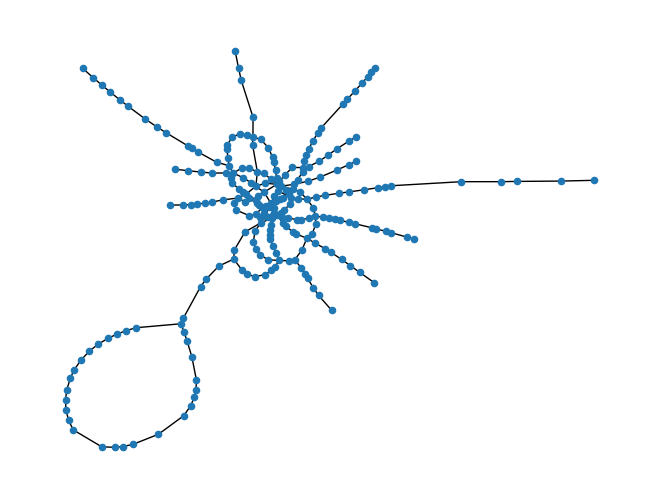

In [ ]:
nx.draw_kamada_kawai(distances_G,with_labels=False,node_size=20)

## Network Statistics

In [ ]:
num_nodes = weights_G.number_of_nodes()
num_edges = weights_G.number_of_edges()

# Average degree
avg_degree = np.mean([d for n, d in weights_G.degree()])

# Density
density = nx.density(weights_G)

# Degree distribution
degree_hist = nx.degree_histogram(weights_G)

# Average clustering coefficient
avg_clustering = nx.average_clustering(weights_G)

# Diameter of the network
diameter = nx.diameter(distances_G,weight="weight")

# computes average shortest path length
if nx.is_connected(distances_G):
    avg_shortest_path_length = nx.average_shortest_path_length(distances_G,weight="weight")
else:
    avg_shortest_path_length = "Graph is not connected"

# betweenness centrality
betweenness_centrality = nx.betweenness_centrality(weights_G)

# printing everything
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Average degree:", avg_degree)
print("Density:", density)
print("Degree distribution:", degree_hist)
print("Average clustering coefficient:", avg_clustering)
print("Diameter in km:", diameter)
print("Average shortest path length in km:", avg_shortest_path_length)
print("Betweenness centrality (top 5 nodes):\n")
for item in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(item)
    print("\n")

Number of nodes: 241
Number of edges: 275
Average degree: 2.2821576763485476
Density: 0.009508990318118948
Degree distribution: [0, 11, 195, 4, 22, 6, 2, 1]
Average clustering coefficient: 0.007804781663702826
Diameter in km: 58.449866424890416
Average shortest path length in km: 14.27420004421963
Betweenness centrality (top 5 nodes):

('GREGORIO MARAÑON', 0.32142145903259917)


('PRINCIPE PIO', 0.31128962932310195)


('NUEVOS MINISTERIOS', 0.30592224546722424)


('ALONSO MARTINEZ', 0.29607820729944173)


('AVENIDA DE AMERICA', 0.2818497482004279)




## Calculating Core Scores 

In [ ]:
A=nx.adjacency_matrix(weights_G).todense()

# define objective function for optimization
# returns error from estimating A by CC^T
def objective(C):
    # C has to be flattened to make scipy work
    C=np.reshape(C,(-1,1))
    A_approx=C @ C.T
    return(np.linalg.norm(A-A_approx,'fro'))

# random guess for initial C
#init_C=np.random.choice([0,1],size=(A.shape[0],))
init_C=np.random.randint(2, size=A.shape[0])
optimized=scipy.optimize.minimize(objective,init_C,method='L-BFGS-B',bounds=[(0,1)]*A.shape[0])

# converts C into binary
best_C=(optimized.x>0.5).astype(int)




In [ ]:
cstation_idx=[]
station_names=[]
for idx, val in enumerate(best_C):
    if val==1:
        cstation_idx.append(idx)

for i in cstation_idx:
    station_names.append(list(weights_G.nodes())[i])

print(station_names)

['SAN BERNARDO', 'SOL', 'CALLAO', 'OPERA', 'ALONSO MARTINEZ', 'TRIBUNAL', 'GRAN VIA', 'BILBAO']


## Node Dynamical Importance

In [ ]:
G_dir=weights_G.to_directed()

In [ ]:
print(nx.is_strongly_connected(G_dir),nx.is_directed(G_dir))

True True


In [ ]:
adj_matrix=nx.adjacency_matrix(G_dir)
e_val,right_vec=scipy.sparse.linalg.eigsh(adj_matrix,k=1,which='LA')
e_val,left_vec=scipy.sparse.linalg.eigsh(np.transpose(adj_matrix),k=1,which='LA')
denom=np.dot(np.transpose(left_vec),right_vec)[0][0]

In [ ]:
node_dynamical_importances=[]

for k in range(len(G_dir.nodes())):
    num=(left_vec[k]*right_vec[k])[0]
    node_dynamical_importances.append(num/denom)

In [ ]:
largest_node_di=pd.DataFrame(node_dynamical_importances).nlargest(10, 0)

largest_node_di.rename(columns={0:'Node Dynamical Importance'}, inplace=True)
largest_node_di['Station']=[list(G_dir.nodes())[idx] for idx in list(largest_node_di.index.values)]
largest_node_di.reset_index(drop=True,inplace=True)
largest_node_di=largest_node_di[["Station","Node Dynamical Importance"]]

In [ ]:
largest_node_di

,Station,Node Dynamical Importance
0,SOL,0.233471
1,CALLAO,0.213119
2,GRAN VIA,0.183753
3,OPERA,0.110656
4,TRIBUNAL,0.042589
5,SEVILLA,0.037289
6,BILBAO,0.026685
7,PLAZA DE ESPAÑA,0.024792
8,CHUECA,0.022326
9,ALONSO MARTINEZ,0.021790


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

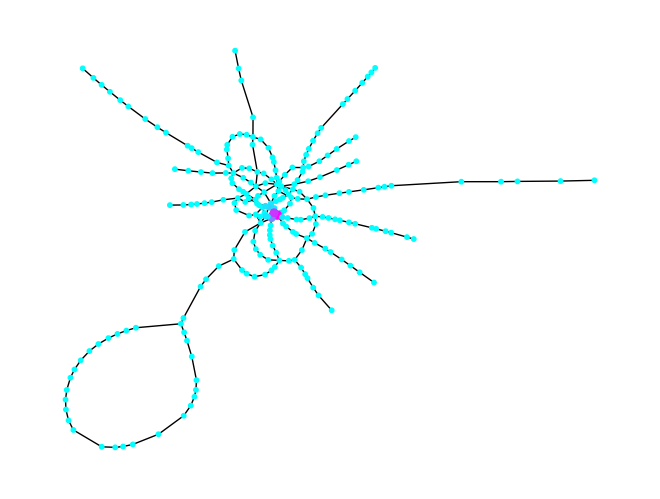

In [ ]:
sizes=(np.array(node_dynamical_importances)+.1)*100
vmin = min(node_dynamical_importances)
vmax = max(node_dynamical_importances)
cmap = plt.cm.cool

nx.draw_kamada_kawai(distances_G,node_color=node_dynamical_importances,with_labels=False,
                     cmap=cmap,vmin=vmin,vmax=vmax,node_size=sizes)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
plt.show()

## Gaster-Newman & Costs

In [ ]:
#Gaster-Newman Model: efficiency of entire network.
distances_G

b1 = 0.183  # avg wait time in hours ~11 minutes
b2 = nx.average_shortest_path_length(distances_G,weight="weight")/32 #avg travel time in hours 

L = nx.average_shortest_path_length(distances_G, weight=lambda u, v, d: b1 + b2 * d['weight'])

m = distances_G.number_of_edges()

alpha = 0.1  

cost = alpha * m + (1 - alpha) * L

print(cost)

35.669657255428504


In [ ]:
print(nx.average_shortest_path_length(distances_G,weight="travel_seconds"))
print(b2)

14.55179806362379
0.4460687513818634


In [ ]:
smallest_node_di=pd.DataFrame(node_dynamical_importances).nsmallest(10, 0)

smallest_node_di.rename(columns={0:'Node Dynamical Importance'}, inplace=True)
smallest_node_di['Station']=[list(G_dir.nodes())[idx] for idx in list(smallest_node_di.index.values)]
smallest_node_di.reset_index(drop=True,inplace=True)
smallest_node_di=smallest_node_di[["Station","Node Dynamical Importance"]]


In [ ]:
#values seem to correlate with node dynamical importance and the daily average stat websites on google doc
#CODE IS COST CHANGE AFTER REMOVING ONE NODE
def calculate_cost(G, b1, b2, alpha):
    b1 = 0.183
    b2 = nx.average_shortest_path_length(G,weight="weight")/32 
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    m = G.number_of_edges()
    alpha = 0.1
    cost = alpha * m + (1 - alpha) * L
    return cost



initial_cost = calculate_cost(distances_G, b1, b2, alpha)
print("Initial Cost Value:", initial_cost)


costs_after_removed = {}

for node in distances_G.nodes(): #recalculate cost after removing a node
    G_removed = distances_G.copy()
    G_removed.remove_node(node)
    
    
    if nx.is_connected(G_removed):
        
        costprime = calculate_cost(G_removed, b1, b2, alpha)
        
       
        costs_after_removed[node] = costprime

#highest & lowest 10 values
costs_df = pd.DataFrame(costs_after_removed.items(), columns=['Node', 'Cost'])
sorted_costs_df = costs_df.sort_values(by='Cost', ascending=False)
"""
print("highest 10 values after removal:")
print(sorted_costs_df.head(10))
"""
print("\nlowest 10 values after removal:")
print(sorted_costs_df.tail(10))


"""#printing stuff
print("Costs after removing:")
for node, cost in costs_after_removed.items():
    print( node, ":", cost)
"""


Initial Cost Value: 35.669657255428504

lowest 10 values after removal:
                      Node       Cost
63   PARQUE DE LOS ESTADOS  35.357156
0             SAN BERNARDO  35.352509
107                 BILBAO  35.345737
17                    GOYA  35.344224
34          CUATRO CAMINOS  35.341858
37         NUÑEZ DE BALBOA  35.333329
21                   CANAL  35.333263
25                  CALLAO  35.321744
66           DIEGO DE LEON  35.302279
59         ALONSO MARTINEZ  35.275597


'#printing stuff\nprint("Costs after removing:")\nfor node, cost in costs_after_removed.items():\n    print( node, ":", cost)\n'

In [ ]:
print("Initial Cost Value:", initial_cost)
avg_cost_change = costs_df['Cost'].mean()
print("avg cost after removing important node:" , sorted_costs_df.tail(10)['Cost'].mean())
print("avg cost change when removing important node:" , initial_cost - sorted_costs_df.tail(10)['Cost'].mean())
print("avg cost after removing random node:" , avg_cost_change)
print("avg cost change when removing a random node:" , initial_cost - avg_cost_change)

Initial Cost Value: 35.669657255428504
avg cost after removing important node: 35.33076953793452
avg cost change when removing important node: 0.33888771749398217
avg cost after removing random node: 35.61666890333957
avg cost change when removing a random node: 0.05298835208893138


In [ ]:
#different code to remove 5 random nodes and recalculate cost scores.
#CODE IS COST CHANGE AFTER REMOVING 5 NODES
def calculate_cost(G, b1, b2, alpha):
    b1 = 0.183
    b2 = nx.average_shortest_path_length(G,weight="weight")/32
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    m = G.number_of_edges()
    alpha = 0.1
    cost = alpha * m + (1 - alpha) * L
    return cost

initial_cost = calculate_cost(distances_G, b1, b2, alpha)
print("Initial Cost Value:", initial_cost)


connected = False
while not connected:
    #Randomly removes 5 nodes. If it disconnects graph, will pick a new one
    random_nodes = random.sample(list(distances_G.nodes()), 5)
    

    
    G_removed = distances_G.copy()
    G_removed.remove_nodes_from(random_nodes)

    
    if nx.is_connected(G_removed):
        connected = True
        cost_after_removal = calculate_cost(G_removed, b1, b2, alpha)
        print("Randomly selected nodes to remove:", random_nodes)
        print("Cost after removing the 5 random nodes:", cost_after_removal)
   

# Calculate the new average cost value
if connected:
    costs_after_removed = {tuple(random_nodes): cost_after_removal}
    new_average_cost = sum(costs_after_removed.values()) / len(costs_after_removed)
    print("New avg cost after removal:", new_average_cost)

Initial Cost Value: 35.669657255428504
Randomly selected nodes to remove: ['ISLAS FILIPINAS', 'PRINCIPE DE VERGARA', 'VENTURA RODRIGUEZ', "O'DONNELL", 'EMPALME']
Cost after removing the 5 random nodes: 35.41479548936575
New avg cost after removal: 35.41479548936575


In [ ]:
#avg recalculated score after removing 5 random nodes (assuming it doesnt break the network)
#CODE IS AVERAGE COST CHANGE AFTER REMOVING 5 RANDOM NODES
#NOT ACTUALLY A HARD AVERAGE, JUST RUNS A BUNCH OF TESTS AND CALCULATES AVERAGE
def calculate_cost(G, b1, b2, alpha):
    b1 = 0.183
    b2 = nx.average_shortest_path_length(G,weight="weight") / 32
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    m = G.number_of_edges()
    alpha = 0.1
    cost = alpha * m + (1 - alpha) * L
    return cost

initial_cost = calculate_cost(distances_G, b1, b2, alpha)
print("Initial Cost Value:", initial_cost)

num_iterations = 50  #calculating 'however many' times to find the average change after removing 5 random nodes
costs_after_removal_list = []

for _ in range(num_iterations):
    connected = False
    while not connected:
        random_nodes = random.sample(list(distances_G.nodes()), 5)

        G_removed = distances_G.copy()
        G_removed.remove_nodes_from(random_nodes)

        if nx.is_connected(G_removed):
            connected = True
            cost_after_removal = calculate_cost(G_removed, b1, b2, alpha)
            print("Cost after removing the 5 random nodes:", cost_after_removal)
            costs_after_removal_list.append(cost_after_removal)
        

# Calculate the new average cost value over all iterations
if costs_after_removal_list:
    new_average_cost = sum(costs_after_removal_list) / len(costs_after_removal_list)
    print("New average cost after removal:", new_average_cost)
else:
    print("No connected graphs were found after node removals.")

Initial Cost Value: 35.669657255428504
Cost after removing the 5 random nodes: 34.98356872683257
Cost after removing the 5 random nodes: 34.80215722661075
Cost after removing the 5 random nodes: 35.241230667618034
Cost after removing the 5 random nodes: 35.99820694647314
Cost after removing the 5 random nodes: 35.03511226408099
Cost after removing the 5 random nodes: 35.0228056897937
Cost after removing the 5 random nodes: 35.169342617145794
Cost after removing the 5 random nodes: 35.08326815953531
Cost after removing the 5 random nodes: 34.74290231641622
Cost after removing the 5 random nodes: 35.09273357661873
Cost after removing the 5 random nodes: 34.95429926401766
Cost after removing the 5 random nodes: 35.860419325015904
Cost after removing the 5 random nodes: 34.896932989749
Cost after removing the 5 random nodes: 34.86395061074317
Cost after removing the 5 random nodes: 34.83621948166879
Cost after removing the 5 random nodes: 34.82176932326976
Cost after removing the 5 random 

In [ ]:
#calculating  local efficiency (assumed as mean geodesic distance) changes with percolation
#code is basically cost function altered for L, since the L in the cost function was
#mean geodesic distance between nodes using Tij for distance
#CODE IS MEAN GEODESIC DIST AFTER REMOVING ONE NODE (LOCAL EFFICIENCY)
def calculate_average_shortest_path_length(G, b1, b2):
    b1 = 0.183
    b2 = nx.average_shortest_path_length(G,weight="weight") / 32
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    return L


initial_L = calculate_average_shortest_path_length(distances_G, b1=None, b2=None)
print("Initial Average Shortest Path Length (L):", initial_L)

L_after_removed = {}

for node in distances_G.nodes():  # Recalculate L after removing a node
    G_removed = distances_G.copy()
    G_removed.remove_node(node)
    
    if nx.is_connected(G_removed):
        L_prime = calculate_average_shortest_path_length(G_removed, b1=None, b2=None)
        L_after_removed[node] = L_prime


L_df = pd.DataFrame(L_after_removed.items(), columns=['Node', 'Average Shortest Path Length'])


sorted_L_df = L_df.sort_values(by='Average Shortest Path Length', ascending=False)
print("\nHighest 10 values (Average Shortest Path Length):")
print(sorted_L_df.head(10))
print("\nLowest 10 values (Average Shortest Path Length):")
print(sorted_L_df.tail(10))

Initial Average Shortest Path Length (L): 9.07739695047611

Highest 10 values (Average Shortest Path Length):
                      Node  Average Shortest Path Length
123            SAN NICASIO                     10.720574
3            PARQUE LISBOA                     10.699256
39            PRINCIPE PIO                     10.578071
64         LEGANES CENTRAL                     10.476480
73        ALCORCON CENTRAL                     10.417648
116                   LAGO                     10.369890
115                  BATAN                     10.324701
65   HOSPITAL SEVERO OCHOA                     10.249529
33            PARQUE OESTE                     10.160097
121         CASA DEL RELOJ                     10.039472

Lowest 10 values (Average Shortest Path Length):
                       Node  Average Shortest Path Length
14        ALONSO DE MENDOZA                      9.030486
56            PARQUE EUROPA                      9.018265
140           AEROPUERTO T4            

In [ ]:
#avg local eff after removing a random node is avg change in efficiency
avg_L_change = L_df['Average Shortest Path Length'].mean()
print("avg local eff after removing random node:" , avg_L_change)

print("avg eff after removing important node:" , sorted_L_df.tail(10)['Average Shortest Path Length'].mean())
print("avg eff change when removing important node:" , initial_L - sorted_L_df.tail(10)['Average Shortest Path Length'].mean())

avg local eff after removing random node: 9.27675855160335
avg eff after removing important node: 8.982970998582207
avg eff change when removing important node: 0.09442595189390346


In [ ]:
#LOOP REMOVAL 5 NODES BAD CODE IGNORE PROBABLY
# Function to calculate the average shortest path length
def calculate_average_shortest_path_length(G, b1, b2):
    b1 = 0.183
    b2 = nx.average_shortest_path_length(G, weight="weight") / 32
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    return L


initial_L = calculate_average_shortest_path_length(distances_G, b1=None, b2=None)
print("Initial Average Shortest Path Length (L):", initial_L)

num_iterations = 10  
L_changes = []

# Looping
for _ in range(num_iterations):
    L_after_removed = []
    G_temp = distances_G.copy()

    # Randomly remove 5 nodes
    random_nodes = random.sample(list(G_temp.nodes()), 5)
    G_temp.remove_nodes_from(random_nodes)

    if nx.is_connected(G_temp):
        L_prime = calculate_average_shortest_path_length(G_temp, b1=None, b2=None)
        L_changes.append(L_prime - initial_L)

# Calculate the average change in L across all iterations
if L_changes:
    average_change_L = sum(L_changes) / len(L_changes)
    print("Average change in Average Shortest Path Length after", num_iterations, "iterations:", average_change_L)
else:
    print("No changes in Average Shortest Path Length were detected after", num_iterations, "iterations.")

Initial Average Shortest Path Length (L): 9.07739695047611
No changes in Average Shortest Path Length were detected after 10 iterations.


In [ ]:
#LOOP REMOVAL 5 NODES
def calculate_average_shortest_path_length(G, b1, b2):
    b1 = 0.183
    b2 = nx.average_shortest_path_length(G, weight="weight") / 32
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    return L

initial_L = calculate_average_shortest_path_length(distances_G, b1=None, b2=None)
print("Initial Average Shortest Path Length (L):", initial_L)

num_iterations = 100 
L_changes = []
L_values_after_removal = []

for _ in range(num_iterations):
    connected = False
    while not connected:
        G_temp = distances_G.copy()
        
        # Randomly remove 5 nodes
        random_nodes = random.sample(list(G_temp.nodes()), 5)
        G_temp.remove_nodes_from(random_nodes)

        if nx.is_connected(G_temp):
            connected = True
            L_prime = calculate_average_shortest_path_length(G_temp, b1=None, b2=None)
            L_changes.append(L_prime - initial_L)
            L_values_after_removal.append(L_prime)
            print(f"Average Shortest Path Length after removing nodes {random_nodes}: {L_prime}")

# Calculate the average change in L across all iterations
if L_changes:
    average_change_L = sum(L_changes) / len(L_changes)
    average_L_after_removal = sum(L_values_after_removal) / len(L_values_after_removal)
    print(f"Average change in Average Shortest Path Length after {num_iterations} iterations: {average_change_L}")
    print(f"Average value of Average Shortest Path Length after {num_iterations} iterations: {average_L_after_removal}")
else:
    print(f"No changes in Average Shortest Path Length were detected after {num_iterations} iterations.")

Initial Average Shortest Path Length (L): 9.07739695047611
Average Shortest Path Length after removing nodes ['QUINTANA', 'GETAFE CENTRAL', 'USERA', 'CONDE DE CASAL', 'CUZCO']: 9.832439765278362
Average Shortest Path Length after removing nodes ['URGEL', 'QUEVEDO', 'GOYA', 'RIOS ROSAS', 'PINAR DEL REY']: 9.410503049073801
Average Shortest Path Length after removing nodes ['DIEGO DE LEON', 'TETUAN', 'LAGUNA', 'LA LATINA', 'USERA']: 10.299186776915672
Average Shortest Path Length after removing nodes ['ANTON MARTIN', 'LORANCA', 'MENDEZ ALVARO', 'OPORTO', 'RETIRO']: 9.958830639373684
Average Shortest Path Length after removing nodes ['IBIZA', 'EMBAJADORES', 'ACACIAS', 'NOVICIADO', 'ISLAS FILIPINAS']: 9.529473757148196
Average Shortest Path Length after removing nodes ['METROPOLITANO', 'AEROPUERTO T4', 'DIEGO DE LEON', 'CRUZ DEL RAYO', 'EL CARMEN']: 9.478186446279283
Average Shortest Path Length after removing nodes ['MONCLOA', 'COLOMBIA', 'BAMBU', 'ARGANDA DEL REY', 'PRADILLO']: 9.7614325

## Global Efficiency

In [ ]:
#code ran very slowly so I used chat gpt to make one that ran the same but was more efficient
#CODE CALCULATES GLOBAL EFFICIENCY (SLOW) AND G.E. CHANGE AFTER REMOVING ONE NODE
#CAN POTENTIALLY IGNORE THIS CODE BUT IM KEEPING IT HERE CUZ IT WORKS ITS JUST REALLY SLOW
def global_efficiency(G):
    n = len(G)
    inv_shortest_paths = 0
    for u in G:
        for v in G:
            if u != v:
                try:
                    inv_shortest_paths += 1 / nx.shortest_path_length(G, u, v, weight='weight')
                except nx.NetworkXNoPath:
                    inv_shortest_paths += 0
    return inv_shortest_paths / (n * (n - 1))


initial_global_efficiency = global_efficiency(distances_G)
print("Initial Global Efficiency:", initial_global_efficiency)

efficiencies_after_removed = {}

for node in distances_G.nodes():  # recalculate efficiency after removing a node
    G_removed = distances_G.copy()
    G_removed.remove_node(node)
    
    if nx.is_connected(G_removed):
        costprime = calculate_cost(G_removed, b1, b2, alpha)
        efficiency_prime = global_efficiency(G_removed)
        
        costs_after_removed[node] = costprime
        efficiencies_after_removed[node] = efficiency_prime

efficiencies_df = pd.DataFrame(efficiencies_after_removed.items(), columns=['Node', 'Global Efficiency'])


sorted_efficiencies_df = efficiencies_df.sort_values(by='Global Efficiency', ascending=False)
print("\nHighest 10 values (Global Efficiency):")
print(sorted_efficiencies_df.head(10))
print("\nLowest 10 values (Global Efficiency):")
print(sorted_efficiencies_df.tail(10))

Initial Global Efficiency: 0.13324442316582838


KeyboardInterrupt: 

In [ ]:
#MORE EFFICIENT FORM OF THE CODE DIRECTLY ABOVE SOURCED FROM CHATGPT
#CODE CALCULATES GLOBAL EFFICIENCY (FASTER) AND G.E. CHANGE AFTER REMOVING ONE NODE
def global_efficiency(G, shortest_path_lengths):
    n = len(G)
    inv_shortest_paths = 0
    for u in G:
        for v in G:
            if u != v:
                try:
                    inv_shortest_paths += 1 / shortest_path_lengths[u][v]
                except KeyError:
                    inv_shortest_paths += 0
    return inv_shortest_paths / (n * (n - 1))

# Precompute shortest path lengths for the original graph
shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(distances_G))

initial_global_efficiency = global_efficiency(distances_G, shortest_path_lengths)
print("Initial Global Efficiency:", initial_global_efficiency)

efficiencies_after_removed = {}

for node in distances_G.nodes():  # Recalculate efficiency after removing a node
    G_removed = distances_G.copy()
    G_removed.remove_node(node)
    
    if nx.is_connected(G_removed):
        # Precompute shortest path lengths for the modified graph
        shortest_path_lengths_removed = dict(nx.all_pairs_dijkstra_path_length(G_removed))
        efficiency_prime = global_efficiency(G_removed, shortest_path_lengths_removed)
        efficiencies_after_removed[node] = efficiency_prime


efficiencies_df = pd.DataFrame(efficiencies_after_removed.items(), columns=['Node', 'Global Efficiency'])


sorted_efficiencies_df = efficiencies_df.sort_values(by='Global Efficiency', ascending=False)
print("\nHighest 10 values (Global Efficiency):")
print(sorted_efficiencies_df.head(10))
print("\nLowest 10 values (Global Efficiency):")
print(sorted_efficiencies_df.tail(10))

Initial Global Efficiency: 0.13324442316582838

Highest 10 values (Global Efficiency):
                       Node  Global Efficiency
2           ARGANDA DEL REY           0.134077
16   HOSPITAL INFANTA SOFÍA           0.133974
140           AEROPUERTO T4           0.133916
63    PARQUE DE LOS ESTADOS           0.133845
62           ARROYO CULEBRO           0.133838
8      HOSPITAL DEL HENARES           0.133833
72               LA FORTUNA           0.133779
57      FUENLABRADA CENTRAL           0.133777
15            CONSERVATORIO           0.133775
139         VILLAVERDE ALTO           0.133770

Lowest 10 values (Global Efficiency):
                   Node  Global Efficiency
107              BILBAO           0.130911
54      TIRSO DE MOLINA           0.130864
49       MANUEL BECERRA           0.130741
80            LA LATINA           0.130643
34       CUATRO CAMINOS           0.130283
59      ALONSO MARTINEZ           0.129876
26                OPERA           0.128921
39         PR

In [ ]:
#avg global eff after removing a random node is avg change in efficiency
avg_eff_change = efficiencies_df['Global Efficiency'].mean()
print("avg eff after removing random node:" , avg_eff_change)

print("avg eff after removing important node:" , sorted_efficiencies_df.tail(10)['Global Efficiency'].mean())
print("avg eff change when removing important node:" , initial_global_efficiency - sorted_efficiencies_df.tail(10)['Global Efficiency'].mean())

avg eff after removing random node: 0.1323159186051389
avg eff after removing important node: 0.12929017066068607
avg eff change when removing important node: 0.003954252505142308


In [ ]:
#CODE IS REMOVING ONE RANDOM NODES AND CHANGE IN EFFICIENCY
def global_efficiency(G, shortest_path_lengths):
    n = len(G)
    inv_shortest_paths = 0
    for u in G:
        for v in G:
            if u != v:
                try:
                    inv_shortest_paths += 1 / shortest_path_lengths[u][v]
                except KeyError:
                    inv_shortest_paths += 0
    return inv_shortest_paths / (n * (n - 1))

# Precompute shortest path lengths for the original graph
shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(distances_G))

initial_global_efficiency = global_efficiency(distances_G, shortest_path_lengths)
print("Initial Global Efficiency:", initial_global_efficiency)

connected = False
while not connected:
    # Randomly remove 1 node. If it disconnects graph, will pick a new one
    random_node = random.choice(list(distances_G.nodes()))

    G_removed = distances_G.copy()
    G_removed.remove_node(random_node)
    

    if nx.is_connected(G_removed):
        connected = True
        # Precompute shortest path lengths for the modified graph
        shortest_path_lengths_removed = dict(nx.all_pairs_dijkstra_path_length(G_removed))
        # Calculate global efficiency after removal
        efficiency_after_removal = global_efficiency(G_removed, shortest_path_lengths_removed)
        print("Randomly selected node to remove:", random_node)
        print("Global Efficiency after removing the random node:", efficiency_after_removal)
  

if connected:
    efficiencies_after_removed = {random_node: efficiency_after_removal}
    new_average_efficiency = sum(efficiencies_after_removed.values()) / len(efficiencies_after_removed)
    print("New avg global efficiency after removal:", new_average_efficiency)

Initial Global Efficiency: 0.13324442316582838
Randomly selected node to remove: ANTON MARTIN
Global Efficiency after removing the random node: 0.131561471052263
New avg global efficiency after removal: 0.131561471052263


In [ ]:
#CODE IS REMOVING 5 RANDOM NODES AND CHANGE IN EFFICIENCY
def global_efficiency(G, shortest_path_lengths):
    n = len(G)
    inv_shortest_paths = 0
    for u in G:
        for v in G:
            if u != v:
                try:
                    inv_shortest_paths += 1 / shortest_path_lengths[u][v]
                except KeyError:
                    inv_shortest_paths += 0
    return inv_shortest_paths / (n * (n - 1))

# Precompute shortest path lengths for the original graph
shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(distances_G))

initial_global_efficiency = global_efficiency(distances_G, shortest_path_lengths)
print("Initial Global Efficiency:", initial_global_efficiency)

connected = False
while not connected:
    # Randomly remove 5 nodes. If it disconnects graph, will pick a new one
    random_nodes = random.sample(list(distances_G.nodes()), 5)
   
    
    
    G_removed = distances_G.copy()
    G_removed.remove_nodes_from(random_nodes)
    
   
    if nx.is_connected(G_removed):
        connected = True
        # Precompute shortest path lengths for the modified graph
        shortest_path_lengths_removed = dict(nx.all_pairs_dijkstra_path_length(G_removed))
        # Calculate global efficiency after removal
        efficiency_after_removal = global_efficiency(G_removed, shortest_path_lengths_removed)
        print("Randomly selected nodes to remove:", random_nodes)
        print("Global Efficiency after removing the 5 random nodes:", efficiency_after_removal)
   
if connected:
    efficiencies_after_removed = {tuple(random_nodes): efficiency_after_removal}
    new_average_efficiency = sum(efficiencies_after_removed.values()) / len(efficiencies_after_removed)
    print("New avg global efficiency after removal:", new_average_efficiency)

Initial Global Efficiency: 0.13324442316582838
Randomly selected nodes to remove: ['LA LATINA', 'PINAR DE CHAMARTIN', 'CANILLAS', 'LAGO', 'LA FORTUNA']
Global Efficiency after removing the 5 random nodes: 0.12815301050132544
New avg global efficiency after removal: 0.12815301050132544


In [ ]:
#LOOPING THE CODE IS REMOVING 5 RANDOM NODES AND CHANGE IN EFFICIENCY
def global_efficiency(G, shortest_path_lengths):
    n = len(G)
    inv_shortest_paths = 0
    for u in G:
        for v in G:
            if u != v:
                try:
                    inv_shortest_paths += 1 / shortest_path_lengths[u][v]
                except KeyError:
                    inv_shortest_paths += 0
    return inv_shortest_paths / (n * (n - 1))

# Function to calculate the cost
def calculate_cost(G, b1, b2, alpha):
    b1 = 0.08
    b2 = nx.average_shortest_path_length(G, weight="weight") / 30
    L = nx.average_shortest_path_length(G, weight=lambda u, v, d: b1 + b2 * d['weight'])
    m = G.number_of_edges()
    alpha = 0.5
    cost = alpha * m + (1 - alpha) * L
    return cost

# Initial global efficiency
    initial_global_efficiency = global_efficiency(distances_G, shortest_path_lengths)
    print("Initial Global Efficiency:", initial_global_efficiency)

num_iterations = 100  # Number of iterations
efficiencies_after_removal_list = []



# Loop for the specified number of iterations
for _ in range(num_iterations):
    # Precompute shortest path lengths for the original graph
    shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(distances_G))

    

    connected = False
    while not connected:
        # Randomly remove 5 nodes
        random_nodes = random.sample(list(distances_G.nodes()), 5)
        G_removed = distances_G.copy()
        G_removed.remove_nodes_from(random_nodes)

        if nx.is_connected(G_removed):
            connected = True
            # Precompute shortest path lengths for the modified graph
            shortest_path_lengths_removed = dict(nx.all_pairs_dijkstra_path_length(G_removed))
            # Calculate global efficiency after removal
            efficiency_after_removal = global_efficiency(G_removed, shortest_path_lengths_removed)
            efficiencies_after_removal_list.append(efficiency_after_removal)
            print("Global Efficiency after removing the 5 random nodes:", efficiency_after_removal)

# Calculate the new average global efficiency value over all iterations
if efficiencies_after_removal_list:
    new_average_efficiency = sum(efficiencies_after_removal_list) / len(efficiencies_after_removal_list)
    print("New average global efficiency after removal:", new_average_efficiency)
else:
    print("No connected graphs were found after node removals.")

Global Efficiency after removing the 5 random nodes: 0.13112976515857136
Global Efficiency after removing the 5 random nodes: 0.12652374455174306
Global Efficiency after removing the 5 random nodes: 0.13008466626109777
Global Efficiency after removing the 5 random nodes: 0.13224331423541946
Global Efficiency after removing the 5 random nodes: 0.13096841986524563
Global Efficiency after removing the 5 random nodes: 0.13002531137117102
Global Efficiency after removing the 5 random nodes: 0.1235215033275129
Global Efficiency after removing the 5 random nodes: 0.12955081859627934
Global Efficiency after removing the 5 random nodes: 0.1266467487323962
Global Efficiency after removing the 5 random nodes: 0.12952998053541348
Global Efficiency after removing the 5 random nodes: 0.128894014655261
Global Efficiency after removing the 5 random nodes: 0.12221076981634516
Global Efficiency after removing the 5 random nodes: 0.12993350947562823
Global Efficiency after removing the 5 random nodes: 0.

## Discussion of Important Nodes (Robustness Analysis)

Nodes with highest betweeness centrality:

('GREGORIO MARAÑON', 0.32142145903259917)
('PRINCIPE PIO', 0.31128962932310195)
('NUEVOS MINISTERIOS', 0.30592224546722424)
('ALONSO MARTINEZ', 0.29607820729944173)
('AVENIDA DE AMERICA', 0.2818497482004279)

Nodes with the highest dynamical importance:
(i.e, when this station is closed, how does this affect the system?)

('SOL',0.2334714507)
('CALLAO', 0.2131194517)
('GRAN VIA',0.1837528812)
('OPERA', 0.1106556144)
('TRIBUNAL',0.0425894872)

Nodes in the core of the network (calculate from core-periphery structures):

('SAN BERNARDO', 'SOL', 'CALLAO', 'OPERA', 'ALONSO MARTINEZ', 'TRIBUNAL', 'GRAN VIA', 'BILBAO')

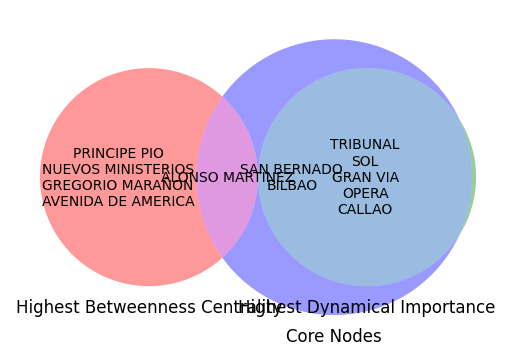

In [ ]:
from matplotlib_venn import venn3
top_BC={'GREGORIO MARAÑON','PRINCIPE PIO','NUEVOS MINISTERIOS','ALONSO MARTINEZ','AVENIDA DE AMERICA'}
top_DN={'SOL',"CALLAO","GRAN VIA","OPERA","TRIBUNAL"}
core_nodes={"SAN BERNADO","SOL","CALLAO","OPERA","ALONSO MARTINEZ","TRIBUNAL",'GRAN VIA','BILBAO'}

categories = {
    'Highest Betweenness Centrality': top_BC,
    'Highest Dynamical Importance': top_DN,
    'Core Nodes': core_nodes
}
v=venn3([top_BC,top_DN,core_nodes],categories)

def set_label(subset, value):
    v.get_label_by_id(subset).set_text('\n'.join(value))

#Setting the labels for each subset
set_label('100', top_BC - top_DN - core_nodes)
set_label('010', top_DN - top_BC - core_nodes)
set_label('001', core_nodes - top_BC - top_DN)
#set_label('110', top_BC & top_DN - core_nodes)
set_label('101', top_BC & core_nodes - top_DN)
set_label('011', top_DN & core_nodes - top_BC)
#set_label('111', top_BC & top_DN & core_nodes)



plt.show() 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c9a2c0d-2aa1-4a88-8c9a-28985e30940c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>